In [2]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats
library(mltools)
library(data.table)
library(VIM)
library(lubridate)
library(caret)
library(CatEncoders)
library(ROSE)
library(catboost)
library(UBL)
library(DMwR)
# package for pr.curve
library(PRROC)
library(ROCR)
library(gbm)
library(xgboost)
## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

#list.files(path = "../input")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions
library(jsonlite)
library(stringr)
library(feather)
#group_by
library(dplyr)
#plot, ggplot
library(ggplot2)
library(ggpubr)
## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

print("Reading in files and addressing JSON data...")
#assign correct data types and appropriate column names 
col_types <- cols(
  channelGrouping = col_character(),
  customDimensions = col_character(),
  date = col_datetime(), # Parses YYYYMMDD
  #date = col_integer(), #lets do the conversion later after ROSE
  device = col_character(),
  fullVisitorId = col_character(),
  geoNetwork = col_character(),
  hits = col_skip(), # MASSIVE amount of data!
  #sessionId = col_character(), # not present in v2 comp; not used anwyay
  socialEngagementType = col_skip(), # Skip as always "Not Socially Engaged"
  totals = col_character(),
  trafficSource = col_character(),
  visitId = col_skip(), # visitId & visitStartTime look identical in all but 5000 cases
  visitNumber = col_integer(),
  visitStartTime = col_skip() # Convert to POSIXlt later,
  #visitStartTime = col_datetime()
  )
# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

#list.files(path = "../input")
train <- read_csv("../input/ga-customer-revenue-prediction/train_v2.csv", col_types = col_types) 
test <- read_csv("../input/ga-customer-revenue-prediction/test_v2.csv",  col_types = col_types)

#which columns includes JSON, JSON-like data
#JSON columns are "device", "geoNetwork", "totals", "trafficSource", "customDimensions"
unsnake <- . %>%
  str_replace_all(c("\\[\\]" = "[{}]", # empty element must contain dictionary
                    "^\\[|\\]$" = "", # remove initial and final brackets
                    "(\\[|\\{|, |: |', )'" = "\\1\"", # open single- to double-quote (on key or value)
                    "'(\\]|\\}|: |, )" = '\"\\1')) # close quote

tr_device <- paste("[", paste(train$device, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_geoNetwork <- paste("[", paste(train$geoNetwork, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_totals <- paste("[", paste(train$totals, collapse = ","), "]") %>% fromJSON(flatten = T)
tr_trafficSource <- paste("[", paste(train$trafficSource, collapse = ","), "]") %>% fromJSON(flatten = T)

tr_customDimensions <- paste("[", paste(unsnake(train$customDimensions), collapse = ","), "]") %>% fromJSON(flatten = T)

te_device <- paste("[", paste(test$device, collapse = ","), "]") %>% fromJSON(flatten = T)
te_geoNetwork <- paste("[", paste(test$geoNetwork, collapse = ","), "]") %>% fromJSON(flatten = T)
te_totals <- paste("[", paste(test$totals, collapse = ","), "]") %>% fromJSON(flatten = T)
te_trafficSource <- paste("[", paste(test$trafficSource, collapse = ","), "]") %>% fromJSON(flatten = T)

te_customDimensions <- paste("[", paste(unsnake(test$customDimensions), collapse = ","), "]") %>% fromJSON(flatten = T)

#Combine to make the full training and test sets. campaignCode in train is dropped.
flat.train <- train %>%
    cbind(tr_device, tr_geoNetwork, tr_totals, tr_trafficSource, tr_customDimensions) %>%
    select(-device, -geoNetwork, -totals, -trafficSource, -customDimensions, -campaignCode)
    
    
flat.test <- test %>%
    cbind(te_device, te_geoNetwork, te_totals, te_trafficSource, te_customDimensions) %>%
    select(-device, -geoNetwork, -totals, -trafficSource, -customDimensions)

#Remove temporary tr_ and te_ sets
rm(tr_device); rm(tr_geoNetwork); rm(tr_totals); rm(tr_trafficSource); rm(tr_customDimensions)
rm(te_device); rm(te_geoNetwork); rm(te_totals); rm(te_trafficSource); rm(te_customDimensions)

flat.train.red <- flat.train %>%
    select(-browserVersion, -browserSize, -operatingSystemVersion, -mobileDeviceInfo, -mobileDeviceBranding, -mobileDeviceModel, 
           -mobileInputSelector, -mobileDeviceMarketingName, -flashVersion, -language, -screenColors, 
           -screenResolution, -cityId,-latitude, -longitude, -networkLocation, -visits, -bounces, -newVisits, 
           -isTrueDirect, -adwordsClickInfo.criteriaParameters, -adwordsClickInfo.isVideoAd, -index, 
          -adwordsClickInfo.gclId, -metro, -transactions, -transactionRevenue, -keyword, 
           -referralPath, -adContent, -campaign, -adwordsClickInfo.page, -adwordsClickInfo.slot, 
           -adwordsClickInfo.adNetworkType)
 
flat.test.red <- flat.test %>%
    select(-browserVersion, -browserSize, -operatingSystemVersion, -mobileDeviceInfo, -mobileDeviceBranding, -mobileDeviceModel, 
           -mobileInputSelector, -mobileDeviceMarketingName, -flashVersion, -language, -screenColors, 
           -screenResolution, -cityId,-latitude, -longitude, -networkLocation, -visits, -bounces, -newVisits, 
           -isTrueDirect, -adwordsClickInfo.criteriaParameters, -adwordsClickInfo.isVideoAd, -index,
          -adwordsClickInfo.gclId, -metro, -transactions, -transactionRevenue, -keyword, 
           -referralPath, -adContent, -campaign, -adwordsClickInfo.page, -adwordsClickInfo.slot, 
           -adwordsClickInfo.adNetworkType)

#setequal(names(flat.train.red), names(flat.test.red))
## Saving data
#write.csv(flat.train.red, "train_flat.csv", row.names = F)
#write.csv(flat.test.red, "test_flat.csv", row.names = F)

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

[1] "Reading in files and addressing JSON data..."


In [3]:
print("Data preparation...")
#----------------------------------
dup_train <- flat.train.red
dup_test <- flat.test.red

#print("Combining train and test samples...")
dup_train <- rbind(dup_train, dup_test)
str(dup_train)
#attributes type conversion
#dup_train$visitId <- as.character(dup_train$visitId)
# Numeric type conversion
cols.nam <- c("visitNumber", "hits","pageviews","sessionQualityDim","timeOnSite",
             "totalTransactionRevenue")
dup_train[cols.nam] <- sapply(dup_train[cols.nam],as.numeric)
#----------------------------------------
#print("Removing near-zero variance attributes...")
##nzv <- nearZeroVar(dup_train)
##dup_train <- dup_train[, -nzv]

##print("Identifying highly correlated attributes...")
##train.cor <-  cor(select_if(dup_train, is.numeric), use = "complete.obs")
##high.cor.att <- findCorrelation(train.cor, cutoff = .75, names=TRUE)#to drop pageviews and transactionRevenue

# pageviews and transactionRevenue highly correlated with hits and totalTransactionRevenue recpectively
# The dataset data dictionary also suggests using totalTransactionRevenue instead of transactionRevenue 
# as it is deprecated.
#high.cor.att # lets keep pageviews
#dup_train <- select(dup_train, -c(all_of(high.cor.att)))

#dup_train <- select(dup_train, -transactionRevenue)
#-----------------------------------------
print("Missing Values Ratio...")
#-----------------------------------------
funcMissRatio <- function(x, y){
    n <- vector()
    n <- rep(NA, length(x))
    missRatio <- cbind(x, n)

    for (i in 1:length(x)){
        y[x[i]][y[x[i]] == "(not set)"] <- NA
        y[x[i]][y[x[i]] == "not available in demo dataset"] <- NA
        y[x[i]][y[x[i]] == "unknown.unknown"] <- NA
        y[x[i]][y[x[i]] == "(none)"] <- NA
        y[x[i]][y[x[i]] == "(not provided)"] <- NA
        missRatio[i, 2] <- sum(is.na(y[x[i]]))/nrow(y)*100
    }
    print(missRatio)
    return(y)
}
# Start we geographical data as we will use it for further impute other attributes NAs, e.g., continent, subContinent
cols.nam <- c("continent", "subContinent", "country", "city", "region", "networkDomain")
dup_train <- funcMissRatio(cols.nam, dup_train)
#--------------------------------------------
print("Imputing NAs...")
#if all geo data are NA in the row
dup_train$continent[which(is.na(dup_train$networkDomain)&is.na(dup_train$city)& is.na(dup_train$metro)
    &is.na(dup_train$region)&is.na(dup_train$country) 
    &is.na(dup_train$continent)& is.na(dup_train$subContinent))] <- names(which.max(table(dup_train$continent[!is.na(dup_train$continent)])))
#sum(is.na(dup_train$continent))
#------------------------------------------
#region, city, networkDomain for some continent == NA are available
#from those we can extract continent value
temp <- dup_train %>%
    group_by(region) %>%
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$region)), dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$region)),
                                c("region")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.region.."))
nullatt <- rename(nullatt, c("region" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.region...."))

nullatt <- merge(temp, nullatt, by = c("region")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$region)), nullatt$narows)
dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#------------------------------------------
temp <- dup_train %>%
    group_by(city) %>%
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$city)), dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$city)),
                                c("city")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.city.."))
nullatt <- rename(nullatt, c("city" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.city...."))

nullatt <- merge(temp, nullatt, by = c("city")) 
nullatt <- nullatt[order(nullatt$narows),]

#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$city)), nullatt$narows)
dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#-------------------------------------------
temp <- dup_train %>%
    group_by(networkDomain) %>%
    filter(!is.null(names(which.max(table(continent[!is.na(continent)]))))&!is.na(continent)) %>% #some networkDomain groups has no corresponding 
# continent result in NULL value, we filter them out to avoid error in summarize
    summarize(continent = names(which.max(table(continent[!is.na(continent)]))))       

nullatt <- data.frame(which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), 
                      dup_train[which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), c("networkDomain")])

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.continent.....is.na.dup_train.networkDomain.."))
nullatt <- rename(nullatt, c("networkDomain" = "dup_train.which.is.na.dup_train.continent.....is.na.dup_train.networkDomain...."))

nullatt <- merge(temp, nullatt, by = c("networkDomain")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$continent)&!is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$continent[nullatt$narows] <- nullatt$continent
#sum(is.na(dup_train$continent))
#----------------------------------------------
# The corresponding networkDomain data do not provide any geo info, we may want to set them to NA
dup_train$continent[which(is.na(dup_train$continent))] <- names(which.max(table(dup_train$continent[!is.na(dup_train$continent)])))
#sum(is.na(dup_train$continent))
#-----------------------------------------------
#subContinent
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(subContinent)) %>%
    summarize(maxlevel = names(which.max(table(subContinent[!is.na(subContinent)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$subContinent)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$subContinent))))
#nullatt
nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.subContinent.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$subContinent)), nullatt$narows)

dup_train$subContinent[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$subContinent))
#--------------------------------------------
#country
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(country)) %>%
    summarize(maxlevel = names(which.max(table(country[!is.na(country)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$country)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$country))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.country.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$country)), nullatt$narows)

dup_train$country[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$country))
#---------------------------------------------
#networkDomain
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent, country) %>%
    filter(!is.na(networkDomain)) %>%
    summarize(maxlevel = names(which.max(table(networkDomain[!is.na(networkDomain)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$networkDomain)),
                                c("totalTransactionRevenue", "continent", "subContinent", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$networkDomain))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.networkDomain.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent", "country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$networkDomain[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$networkDomain))
# Second round to addess NAs based on continent
# if (setequal(which(is.na(dup_train$timeOnSite)), nullatt$narows) == FALSE)
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(networkDomain)) %>%
    summarize(maxlevel = names(which.max(table(networkDomain[!is.na(networkDomain)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$networkDomain)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$networkDomain))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.networkDomain.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$networkDomain[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$networkDomain))
#----------------------------------------
#city
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent, country) %>%
    filter(!is.na(city)) %>%
    summarize(maxlevel = names(which.max(table(city[!is.na(city)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$city)),
                                c("totalTransactionRevenue", "continent", "subContinent", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$city))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.city.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent", "country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$country)), nullatt$narows)

dup_train$city[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$city))
# second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(city)) %>%
    summarize(maxlevel = names(which.max(table(city[!is.na(city)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$city)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$city))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.city.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$city[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$city))
# third round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(city)) %>%
    summarize(maxlevel = names(which.max(table(city[!is.na(city)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$city)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$city))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.city.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$networkDomain)), nullatt$narows)

dup_train$city[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$city))
#---------------------------------------------
print("Missing Values Ratio...")
# Computing NA ratio
cols.nam <- c("visitNumber", "hits", "pageviews", "sessionQualityDim", "timeOnSite")
dup_train <- funcMissRatio(cols.nam, dup_train)
#pageviews
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(pageviews)) %>%
    summarize(meanatt = mean(pageviews))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$pageviews)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$pageviews))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.pageviews.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$pageviews[nullatt$narows] <- nullatt$meanatt
sum(is.na(dup_train$pageviews))
# sessionQualityDim
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(sessionQualityDim)) %>%
    summarize(meanatt = mean(sessionQualityDim))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$sessionQualityDim)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$sessionQualityDim))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.sessionQualityDim.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$sessionQualityDim[nullatt$narows] <- nullatt$meanatt
# The second round to addess NAs based on continent
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(sessionQualityDim)) %>%
    summarize(meanatt = mean(sessionQualityDim))
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

#sum(is.na(dup_train$sessionQualityTime))
which(is.na(dup_train$sessionQualityTime))
nullatt <- data.frame(dup_train[which(is.na(dup_train$sessionQualityDim)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$sessionQualityDim))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.sessionQualityDim.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$sessionQualityDim[nullatt$narows] <- nullatt$meanatt
#----------------------------------------
#timeOnSite
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent, subContinent) %>%
    filter(!is.na(timeOnSite)) %>%
    summarize(meanatt = mean(timeOnSite))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$timeOnSite)),
                                c("totalTransactionRevenue", "continent", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$timeOnSite))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.timeOnSite.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent", "subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$timeOnSite[nullatt$narows] <- nullatt$meanatt
#sum(is.na(dup_train$timeOnSite))
#if (setequal(which(is.na(dup_train$timeOnSite)), nullatt$narows) == FALSE)
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(timeOnSite)) %>%
    summarize(meanatt = mean(timeOnSite))
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$timeOnSite)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$timeOnSite))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.timeOnSite.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$timeOnSite[nullatt$narows] <- nullatt$meanatt
#---------------------------------------
# channelGrouping NAs: no NA but has (Other) level
dup_train %>% 
  filter(!is.na(channelGrouping)) %>%
  count(channelGrouping, sort = TRUE)
#----------------------------------------
print("Missing Values Ratio...")
cols.nam <- c("operatingSystem","browser","isMobile","deviceCategory")
dup_train <- funcMissRatio(cols.nam, dup_train)
#-----------------------------------------------
# operatingSystem
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), deviceCategory) %>%
    filter(!is.na(operatingSystem)) %>%
    summarize(maxlevel = names(which.max(table(operatingSystem[!is.na(operatingSystem)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$operatingSystem)),
                                c("totalTransactionRevenue", "deviceCategory")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$operatingSystem))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.operatingSystem.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","deviceCategory")) 
nullatt <- nullatt[order(nullatt$narows),]

#setequal(which(is.na(dup_train$operatingSystem)), nullatt$narows)

dup_train$operatingSystem[nullatt$narows] <- nullatt$maxlevel
#----------------------------------------
# browser
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), deviceCategory, operatingSystem) %>%
    filter(!is.na(browser)) %>%
    summarize(maxlevel = names(which.max(table(browser[!is.na(browser)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$browser)),
                                c("totalTransactionRevenue", "deviceCategory", "operatingSystem")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$browser))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.browser.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","deviceCategory", "operatingSystem")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$browser[nullatt$narows] <- nullatt$maxlevel
#--------------------------------------
#str(dup_train)
print("Missing Values Ratio...")
cols.nam <- c("source", "medium", "value")
dup_train <- funcMissRatio(cols.nam, dup_train)
#------------------------------------------------
# source
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), country) %>%
    filter(!is.na(source)) %>%
    summarize(maxlevel = names(which.max(table(source[!is.na(source)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$source)),
                                c("totalTransactionRevenue", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$source))))
#nullatt
nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.source.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","country")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$source[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$source))
#----------------------------------------------------
#medium
# We can address NAs at country then subContinent and finally continent level
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), country) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "country")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","country")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$medium)), nullatt$narows)

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
# Second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), subContinent) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
# Third round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(medium)) %>%
    summarize(maxlevel = names(which.max(table(medium[!is.na(medium)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$medium)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$medium))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.medium.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$medium)), nullatt$narows)

dup_train$medium[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$medium))
#-----------------------------------------------------
# value
#dup_train$value[dup_train$value == "(not set)"] <- NA
#missRatio <- sum(is.na(dup_train$value))/nrow(dup_train)*100
#missRatio

temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), subContinent) %>%
    filter(!is.na(value)) %>%
    summarize(maxlevel = names(which.max(table(value[!is.na(value)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$value)),
                                c("totalTransactionRevenue", "subContinent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$value))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.value.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","subContinent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$value)), nullatt$narows)

dup_train$value[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$value))
# Second round
temp <- dup_train %>%
    group_by(as.logical(totalTransactionRevenue), continent) %>%
    filter(!is.na(value)) %>%
    summarize(maxlevel = names(which.max(table(value[!is.na(value)]))))       
temp <- rename(temp, c("totalTransactionRevenue" = "as.logical(totalTransactionRevenue)"))

nullatt <- data.frame(dup_train[which(is.na(dup_train$value)),
                                c("totalTransactionRevenue", "continent")])
nullatt$totalTransactionRevenue <- as.logical(nullatt$totalTransactionRevenue)
nullatt <- cbind(nullatt, data.frame(which(is.na(dup_train$value))))

nullatt <- rename(nullatt, c("narows" = "which.is.na.dup_train.value.."))
nullatt <- merge(temp, nullatt, by = c("totalTransactionRevenue","continent")) 
nullatt <- nullatt[order(nullatt$narows),]
#setequal(which(is.na(dup_train$value)), nullatt$narows)

dup_train$value[nullatt$narows] <- nullatt$maxlevel
#sum(is.na(dup_train$value))
# Addressing a few remaining NAs in value
dup_train$value[which(is.na(dup_train$value))] <- names(which.max(table(dup_train$value[!is.na(dup_train$value)])))
#sum(is.na(dup_train$value))
print("Checking if all interesting attributes NAs have been addressed...")
cols.nam <- c("visitNumber","hits","pageviews", "sessionQualityDim","timeOnSite","totalTransactionRevenue",
              "operatingSystem","browser","isMobile","deviceCategory", 
              "continent", "subContinent", "country", "region", "city", "networkDomain", 
            "source", "medium", "value")

dup_train <- funcMissRatio(cols.nam, dup_train)

[1] "Data preparation..."
'data.frame':	2109926 obs. of  22 variables:
 $ channelGrouping        : chr  "Organic Search" "Referral" "Direct" "Organic Search" ...
 $ date                   : POSIXct, format: "2017-10-16" "2017-10-16" ...
 $ fullVisitorId          : chr  "3162355547410993243" "8934116514970143966" "7992466427990357681" "9075655783635761930" ...
 $ visitNumber            : int  1 6 1 1 1 1 1 1 1 2 ...
 $ browser                : chr  "Firefox" "Chrome" "Chrome" "Chrome" ...
 $ operatingSystem        : chr  "Windows" "Chrome OS" "Android" "Windows" ...
 $ isMobile               : logi  FALSE FALSE TRUE FALSE FALSE FALSE ...
 $ deviceCategory         : chr  "desktop" "desktop" "mobile" "desktop" ...
 $ continent              : chr  "Europe" "Americas" "Americas" "Asia" ...
 $ subContinent           : chr  "Western Europe" "Northern America" "Northern America" "Western Asia" ...
 $ country                : chr  "Germany" "United States" "United States" "Turkey" ...
 $ region

[1] 0

integer(0)

channelGrouping,n
<chr>,<int>
Organic Search,937341
Social,391852
Direct,349210
Referral,270812
Paid Search,58461
Display,58359
Affiliates,43748
(Other),143


[1] "Missing Values Ratio..."
     x                 n                     
[1,] "operatingSystem" "0.767657254330247"   
[2,] "browser"         "0.000568740325490088"
[3,] "isMobile"        "0"                   
[4,] "deviceCategory"  "0"                   
[1] "Missing Values Ratio..."
     x        n                    
[1,] "source" "0.00331765189869218"
[2,] "medium" "32.105580954024"    
[3,] "value"  "18.6649200019337"   
[1] "Checking if all interesting attributes NAs have been addressed..."
      x                         n                 
 [1,] "visitNumber"             "0"               
 [2,] "hits"                    "0"               
 [3,] "pageviews"               "0"               
 [4,] "sessionQualityDim"       "0"               
 [5,] "timeOnSite"              "0"               
 [6,] "totalTransactionRevenue" "98.9047957132146"
 [7,] "operatingSystem"         "0"               
 [8,] "browser"                 "0"               
 [9,] "isMobile"                "0"

In [6]:
print("Aggregating visitor level data...")
# Function to calculate each categorical attribute mode
catMode = function(x){
    y = names(which.max(table(x)))
    return(y)
} 
#-----------------------------------------
# Generating more attributes extracted from date e.g., day of the week, day of the month, month
#gc()
imbal.data <- dup_train
#rm("dup_train")
#gc()
imbal.data$month <- as.character(month(lubridate::as_datetime(imbal.data$date)))
imbal.data$mday <- as.character(mday(lubridate::as_datetime(imbal.data$date)))
imbal.data$wday <- as.character(wday(lubridate::as_datetime(imbal.data$date)))
#imbal.data$hour <- as.character(hour(lubridate::as_datetime(imbal.data$visitStartTime)))

imbal.data <- select(imbal.data, -c("region"))
#imbal.data <- select(imbal.data, -c("wday", "mday"))
imbal.data$totalTransactionRevenue[which(is.na(imbal.data$totalTransactionRevenue))] <- 0
str(imbal.data)
#--------------------------------------------------
# transforming to visitor level data
temp1.imbal.data <- imbal.data %>%
filter(visitNumber == 1) 
temp1.imbal.data$freqVisit <- (rep(0, nrow(temp1.imbal.data)))
temp1.imbal.data$totalTransactionRevenue <- log1p(temp1.imbal.data$totalTransactionRevenue)
names(temp1.imbal.data)[names(temp1.imbal.data) == "date"] <- "ldate"

temp2.imbal.data <- imbal.data %>% 
group_by(fullVisitorId) %>%
filter(visitNumber != 1) %>%
summarize(channelGrouping = catMode(channelGrouping), visitNumber = max(visitNumber),
         ldate = max(date), browser = catMode(browser), operatingSystem = catMode(operatingSystem), 
         isMobile = catMode(isMobile), deviceCategory = catMode(deviceCategory), continent = catMode(continent), 
         subContinent = catMode(subContinent), country = catMode(country), city = catMode(city),
          networkDomain = catMode(networkDomain),
         hits = mean(hits), pageviews = mean(pageviews), sessionQualityDim = mean(sessionQualityDim), timeOnSite = mean(timeOnSite),
         totalTransactionRevenue = log1p(sum(totalTransactionRevenue)), source = catMode(source),
         medium = catMode(medium), value = catMode(value), month = catMode(month), mday = catMode(mday),
         wday = catMode(wday),
          freqVisit = as.numeric(max(date) - min(date))/max(visitNumber)
         )
temp2.imbal.data <- as.data.frame(temp2.imbal.data)

imbal.data <- rbind(temp1.imbal.data, temp2.imbal.data)

[1] "Aggregating visitor level data..."
'data.frame':	2109926 obs. of  24 variables:
 $ channelGrouping        : chr  "Organic Search" "Referral" "Direct" "Organic Search" ...
 $ date                   : POSIXct, format: "2017-10-16" "2017-10-16" ...
 $ fullVisitorId          : chr  "3162355547410993243" "8934116514970143966" "7992466427990357681" "9075655783635761930" ...
 $ visitNumber            : num  1 6 1 1 1 1 1 1 1 2 ...
 $ browser                : chr  "Firefox" "Chrome" "Chrome" "Chrome" ...
 $ operatingSystem        : chr  "Windows" "Chrome OS" "Android" "Windows" ...
 $ isMobile               : logi  FALSE FALSE TRUE FALSE FALSE FALSE ...
 $ deviceCategory         : chr  "desktop" "desktop" "mobile" "desktop" ...
 $ continent              : chr  "Europe" "Americas" "Americas" "Asia" ...
 $ subContinent           : chr  "Western Europe" "Northern America" "Northern America" "Western Asia" ...
 $ country                : chr  "Germany" "United States" "United States" "Turkey"

[1] "Plotting totalTransactionRevenue vs. date..."


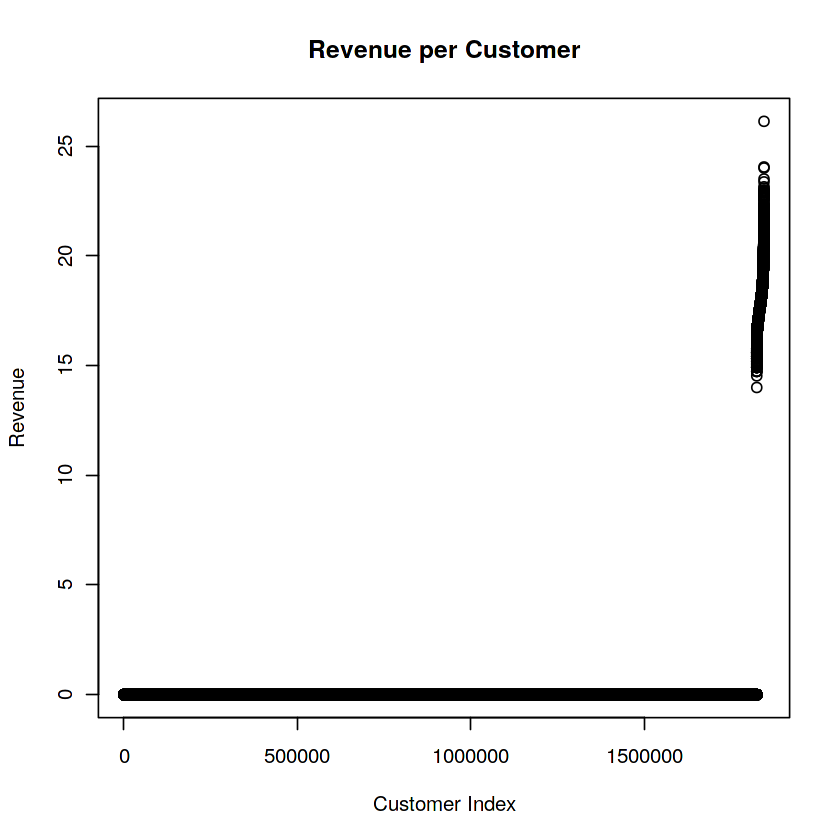

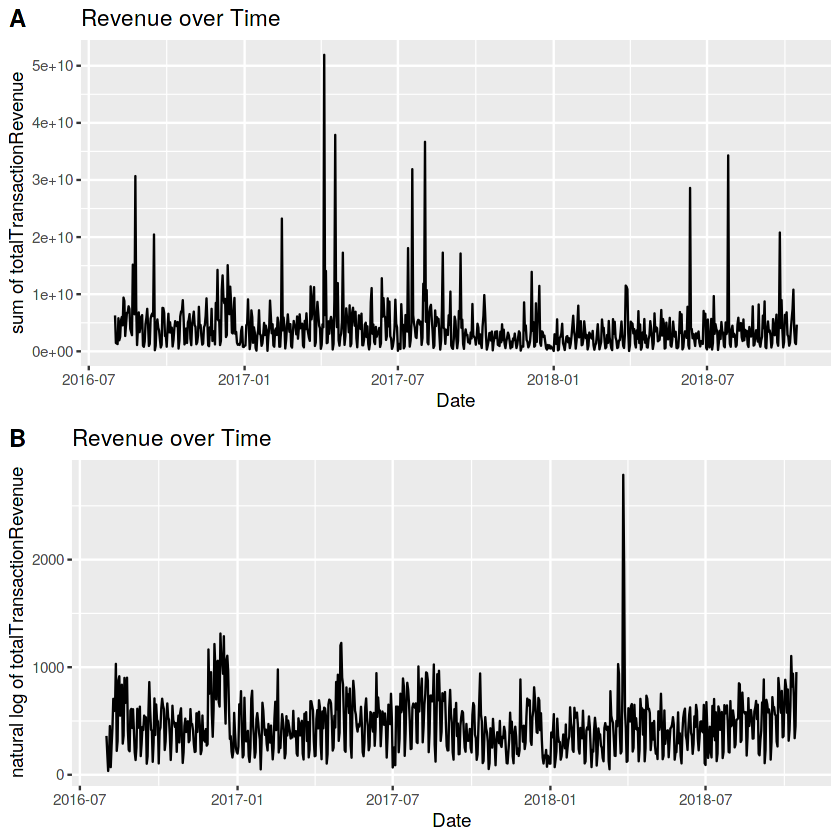

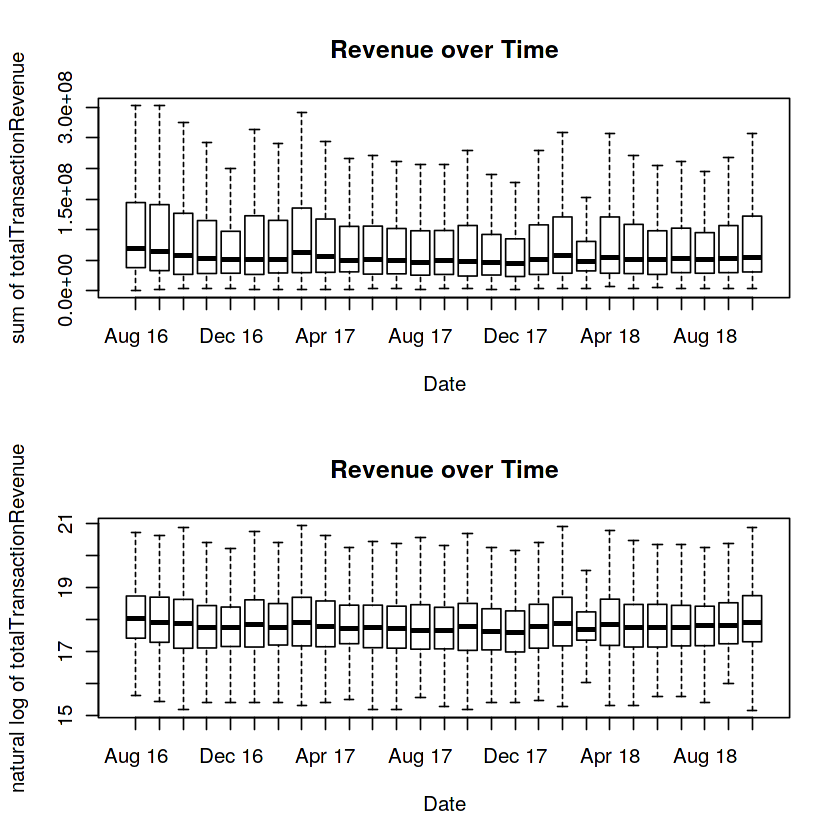

In [8]:
# Visualizing totalTransactionRevenue per session vs. per visitor
# session level data
#str(dup_train)
# visitor level data replacing totalTransactionRevenue with log1p(sum(totalTransactionRevenue))
#str(imbal.data)
# This plot shows a highly imbalanced and skewed dataset
#print(prop.table(table(imbal.data$totalTransactionRevenue)))
plot(sort(imbal.data$totalTransactionRevenue), main = "Revenue per Customer", xlab = "Customer Index", ylab = "Revenue")
#------------------------------------------------
# Now, let's see how the revenue changes over time and how aggregating data at visitor level changes the revenue trend
print("Plotting totalTransactionRevenue vs. date...")
# how log1p or visitor level data transform the dataset e.g., remove random errors, a ibt of seasonality
data.train <- dup_train %>%
  select(date, totalTransactionRevenue) %>%
  filter(!is.na(totalTransactionRevenue))

temp1 <- data.train %>%
  group_by(date) %>%
  #summarize(bCount = n(), sttr = sum(log1p(totalTransactionRevenue))) 
  summarize(bCount = n(), sttr = sum(totalTransactionRevenue)) 

agg.data.train <- imbal.data %>%
  select(ldate, totalTransactionRevenue) %>%
  filter(totalTransactionRevenue != 0)

temp2 <- agg.data.train %>%
  group_by(ldate) %>%
  summarize(bCount = n(), sttr = sum(totalTransactionRevenue)) 
  

g1 <- ggplot(temp1, aes(date, sttr))
r1 <- g1 + geom_line() 
s1 <- r1 + labs(title = "Revenue over Time", x = "Date", y = "sum of totalTransactionRevenue")

g2 <- ggplot(temp2, aes(ldate, sttr))
r2 <- g2 + geom_line() 
s2 <- r2 + labs(title = "Revenue over Time", x = "Date", y = "natural log of totalTransactionRevenue")

ggarrange(s1, s2,
          labels = c("A", "B"),
          ncol = 1, nrow = 2)
# data is changing in unforween patterns over time, not a trend or repetative pattern that occurs every year
# concept drift? update the model with the most recent data

#----------------------------------------
par(mfrow = c(2, 1))
boxplot(data.train$totalTransactionRevenue ~ reorder(format(data.train$date,'%b %y'),data.train$date), outline = FALSE, 
       main = "Revenue over Time", xlab = "Date", ylab = "sum of totalTransactionRevenue") 
#----------------------------------------
boxplot(agg.data.train$totalTransactionRevenue ~ reorder(format(agg.data.train$ldate,'%b %y'),agg.data.train$ldate), outline = FALSE, 
       main = "Revenue over Time", xlab = "Date", ylab = "natural log of totalTransactionRevenue") 
#----------------------------------------
if(FALSE){
ggplot(data.train) +
  geom_boxplot(aes(y=log1p(totalTransactionRevenue),
                   x=reorder(format(date,'%B'),date),
                   fill=format(date,'%Y'))) +
  ylab("Revenue") + xlab('Month') + guides(fill=guide_legend(title="Year")) +
  theme_bw()
#----------------------------------------
ggplot(agg.data.train) +
  geom_boxplot(aes(y=totalTransactionRevenue,
                   x=reorder(format(ldate,'%B'),ldate),
                   fill=format(ldate,'%Y'))) +
  ylab("Revenue") + xlab('Month') + guides(fill=guide_legend(title="Year")) +
  theme_bw()
#----------------------------------------
data.train <- dup_train %>%
  select(visitStartTime, totalTransactionRevenue) %>%
  filter(!is.na(totalTransactionRevenue))#, date >= as.Date("2017-01-01") & date <= as.Date("2017-12-30"))

boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(month(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE) 
boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(wday(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE)
boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(mday(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE)
boxplot(log1p(data.train$totalTransactionRevenue) ~ factor(hour(lubridate::as_datetime(data.train$visitStartTime))), outline = FALSE) 
}

In [9]:
# Preparing data for classification
imbal.data <- rbind(temp1.imbal.data, temp2.imbal.data)

imbal.data$totalTransactionRevenue[which(imbal.data$totalTransactionRevenue != 0)] <- 1

cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value",
             "month", "wday", "mday", "totalTransactionRevenue")

imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
str(imbal.data)
#----------------------------------------------------
# Only NetworkDoamin as it contains lots of very low frequnecy data results in many levels
print("Reducing categorical attributes' levels...")
#cols.nam <- c("browser", "networkDomain", "country", "source")
cols.nam <- c("networkDomain")
catTofac <- function(x, df){
    for (i in 1:length(x)){
        #df[,x[i]] <- fct_lump(df[,x[i]], p = 0.01, w = NULL, other_level = "(Other)")
        # We can go with n = ... to keepp more levels in the analysis
        df[,x[i]] <- fct_lump(df[,x[i]], n = 20, w = NULL, other_level = "(Other)")
    }
    return(df)
}
#dataset <- catTofac(cols.nam, dataset)
imbal.data <- catTofac(cols.nam, imbal.data)
# Not including features extracted from date for now
#library(dplyr)
imbal.data <- select(imbal.data, -c(fullVisitorId, month, mday, wday, pageviews))
str(imbal.data)
#-----------------------------------------
print("Normalizing the dataset...")
cols.nam <- c("visitNumber", "hits", "timeOnSite", "sessionQualityDim", "freqVisit")

pp_norm <- preProcess(imbal.data[cols.nam], 
                      method = c("scale", "center"))
                      #method = c("range"))
imbal.data[cols.nam] <- predict(pp_norm, newdata = imbal.data[cols.nam])
#training <- dataset
#-----------------------------------------
print("Splitting dataset into training and test...")
test.data <- imbal.data %>%
    filter(ldate >= as.Date("2018-05-01"))
training <- imbal.data %>%
    filter(ldate < as.Date("2018-05-01"))
#str(training)
#str(test.data)

'data.frame':	1845118 obs. of  25 variables:
 $ channelGrouping        : Factor w/ 8 levels "(Other)","Affiliates",..: 5 3 5 5 7 7 5 5 5 5 ...
 $ ldate                  : POSIXct, format: "2017-10-16" "2017-10-16" ...
 $ fullVisitorId          : Factor w/ 1617501 levels "0000000259678714014",..: 511379 1292712 1468127 1125680 26964 1350653 214859 1023359 1195109 209244 ...
 $ visitNumber            : num  1 1 1 1 1 1 1 1 1 1 ...
 $ browser                : Factor w/ 159 levels ";__CT_JOB_ID__:051f8c23-a890-4634-b34d-1aeebc201356;",..: 78 59 59 59 59 59 59 59 59 132 ...
 $ operatingSystem        : Factor w/ 25 levels "Android","BlackBerry",..: 23 1 23 23 8 8 23 8 3 8 ...
 $ isMobile               : Factor w/ 2 levels "FALSE","TRUE": 1 2 1 1 1 1 1 1 1 1 ...
 $ deviceCategory         : Factor w/ 3 levels "desktop","mobile",..: 1 2 1 1 1 1 1 1 1 1 ...
 $ continent              : Factor w/ 5 levels "Africa","Americas",..: 4 2 3 2 2 4 4 2 4 4 ...
 $ subContinent           : Factor w/ 22 leve

In [10]:
# memory cleaning before model fitting
sort( sapply(ls(),function(x){object.size(get(x))})) 
rm("funcMissRatio", "nullatt", "test", "dup_test", "flat.test.red", "flat.test",
  "train", "flat.train.red", "dup_train", "flat.train")
gc()

GET_USER_SECRET_ENDPONT           KAGGLE_BASE_URL KAGGLE_USER_SECRETS_TOKEN 
                      136                       136                       328 
                     auth                  cols.nam       TokenBigQueryKernel 
                      352                       424                       552 
                  unsnake                      temp                   pp_norm 
                      856                      3280                      6528 
                col_types           get_user_secret                   catMode 
                     7288                     10728                     13576 
                    temp1                     temp2                        g1 
                    17736                     17752                     23056 
                       g2                        r1                        r2 
                    23072                     23544                     23560 
                       s1                        s2                  catTofac 
                    23792                     23824                     36192 
            funcMissRatio                   nullatt            agg.data.train 
                   131696                    239680                    335192 
               data.train                 test.data          temp2.imbal.data 
                   371112                  36031224                  71309744 
                     test                  dup_test             flat.test.red 
                 85006232                  92712576                  92712576 
                 training                imbal.data                 flat.test 
                156166200                 192044792                 200479928 
                    train            flat.train.red          temp1.imbal.data 
                326058768                 396682784                 442683704 
                dup_train                flat.train 
                495693608                 855735480

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4640556,247.9,14647603,782.3,55876165,2984.2
Vcells,110842477,845.7,348670232,2660.2,435837789,3325.2


In [13]:
# catboost classification
#------------------------------------
# Dealing with categorical features
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
                  "continent","subContinent","country", "city", "networkDomain", 
                  "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("visitNumber", "hits", "freqVisit", "sessionQualityDim", 
                                 "timeOnSite", "totalTransactionRevenue", "ldate")])
    return(df)
}
training <- cat.encode.func(training)
##training <- cat.encode.func(smote.train)
#training <- cat.encode.func(ovun.train)
#validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)
# almost 80% for training and 20% for testing
#dim(training)
#dim(test.data)
#-------------------------------------
training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
# Renaming levels for classProbs = TRUE in TrainControl                  
levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
y_train <- unlist(training[c('totalTransactionRevenue')])
x_train <- select(training, -c("totalTransactionRevenue"))

levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
#str(x_train)
#str(x_test)
#-------------------------------------
# Preparing dataset for timeSlices
temp <- x_train %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
print("Creating time slices for time series cross validation...")
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 2, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}   
#-------------------------------------------
# Create model weights (they sum to one) for weights
#str(x_train)
#cat_att <- unlist(lapply(x_train, class))
#as.data.frame(which(cat_att == "factor"))
#cat_features = c(1, 3:11, 15:17)
#cat_features
model_weights <- ifelse(training$totalTransactionRevenue == "noRev",
                        (1/table(training$totalTransactionRevenue)[1]) * 0.5,
                        (1/table(training$totalTransactionRevenue)[2]) * 0.5)

set.seed(456)   
#set.seed(5346)
fitControl <- trainControl(#method = "timeslice",
                           classProbs = TRUE,
                           #summaryFunction = twoClassSummary,
                           #summaryFunction = prSummary,
                           #savePredictions = TRUE,
                           returnResamp = "all",
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp),
                           # Define subsampling technique inside resampling
                           sampling = "smote",
                           verboseIter = TRUE,
                           #indexFinal = unlist(indexFinal)
)
# ROSE generates samples out of feature space like date, I'd rather date within training period
# Grid Search for tuning the parameters
catboost.grid <- expand.grid(depth = 7, #c(6, 7, 8)
                    learning_rate = 0.5, #c(0.05, 0.1, 0.5)
                    iterations = 200, #c(100,200), #c(50,100,200)
                    l2_leaf_reg = 3, #1e-06
                    rsm = 0.8, #c(0.8,1.0)
                    #class_weights <- c(0.1, 4) 
                    border_count = 255) #c(64, 255), c(64,128,255)) 
print("Model fitting...")
model <- train(x = x_train[, !(colnames(x_train) %in% c("ldate"))], 
               y = y_train,
               #totalTransactionRevenue ~ ., 
               #data  = training,
               method = catboost.caret,
               #method = "gbm",
               #weights = model_weights,
               #per_float_feature_quantization = c('14:border_count=1024', '16:border_count=1024'),
               trControl = fitControl,
               tuneGrid = catboost.grid,
               #tuneLength = 3,
               #metric = "AUC",
               #metric = "F", 
               metric = "Kappa",
               task_type = "CPU",# performance settings
               thread_count = 4 # thread_count equal to the number of cpu cores which is 4  
              )

saveRDS(model, "smote.seed.kappa.catboost.rds")


[1] "Creating time slices for time series cross validation..."


$train
$train$Training01
[1] 1

$train$Training02
[1] 1 2

$train$Training03
[1] 1 2 3

$train$Training04
[1] 1 2 3 4

$train$Training05
[1] 1 2 3 4 5

$train$Training06
[1] 1 2 3 4 5 6

$train$Training07
[1] 1 2 3 4 5 6 7

$train$Training08
[1] 1 2 3 4 5 6 7 8

$train$Training09
[1] 1 2 3 4 5 6 7 8 9

$train$Training10
 [1]  1  2  3  4  5  6  7  8  9 10

$train$Training11
 [1]  1  2  3  4  5  6  7  8  9 10 11

$train$Training12
 [1]  1  2  3  4  5  6  7  8  9 10 11 12

$train$Training13
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13

$train$Training14
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14

$train$Training15
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15

$train$Training16
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16

$train$Training17
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17

$train$Training18
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18

$train$Training19
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19


$test
$test$Testing01
[1] 2 3

$test$Testing02
[1] 3 4

$test$Testing03
[1] 4 5

$test$Testing04
[1] 5 6

$test$Testing05
[1] 6 7

$test$Testing06
[1] 7 8

$test$Testing07
[1] 8 9

$test$Testing08
[1]  9 10

$test$Testing09
[1] 10 11

$test$Testing10
[1] 11 12

$test$Testing11
[1] 12 13

$test$Testing12
[1] 13 14

$test$Testing13
[1] 14 15

$test$Testing14
[1] 15 16

$test$Testing15
[1] 16 17

$test$Testing16
[1] 17 18

$test$Testing17
[1] 18 19

$test$Testing18
[1] 19 20

$test$Testing19
[1] 20 21

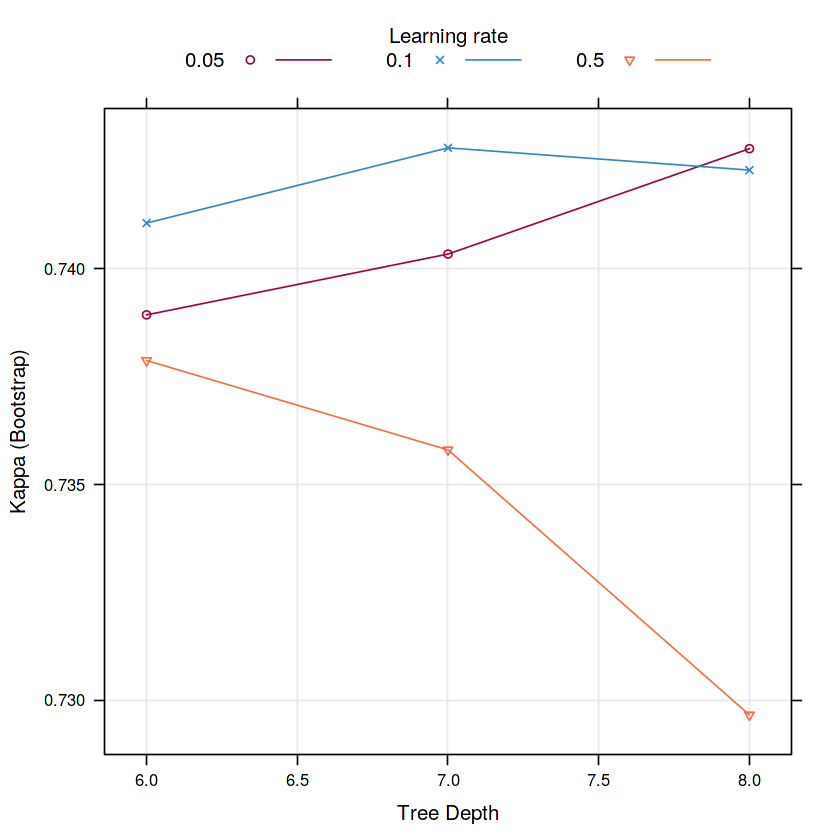

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 339295   3213
     Rev     1323   1156
                                          
               Accuracy : 0.9869          
                 95% CI : (0.9865, 0.9872)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 0.9944          
                                          
                  Kappa : 0.3315          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.264591        
            Specificity : 0.996116        
         Pos Pred Value : 0.466317        
         Neg Pred Value : 0.990619        
             Prevalence : 0.012664        
         Detection Rate : 0.003351        
   Detection Prevalence : 0.007186        
      Balanced Accuracy : 0.630354        
                                          
       'Positive' Class : Rev             
            

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 339295   3213
     Rev     1323   1156
                                          
               Accuracy : 0.9869          
                 95% CI : (0.9865, 0.9872)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 0.9944          
                                          
                  Kappa : 0.3315          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.264591        
            Specificity : 0.996116        
         Pos Pred Value : 0.466317        
         Neg Pred Value : 0.990619        
             Prevalence : 0.012664        
         Detection Rate : 0.003351        
   Detection Prevalence : 0.007186        
      Balanced Accuracy : 0.630354        
                                          
       'Positive' Class : Rev             
            

Sensitivity,0.264591440
Specificity,0.996115883
Pos Pred Value,0.466317063
Neg Pred Value,0.990619197
Precision,0.466317063
Recall,0.264591440
F1,0.337616822
Prevalence,0.012664245
Detection Rate,0.003350851
Detection Prevalence,0.007185778
Balanced Accuracy,0.630353662


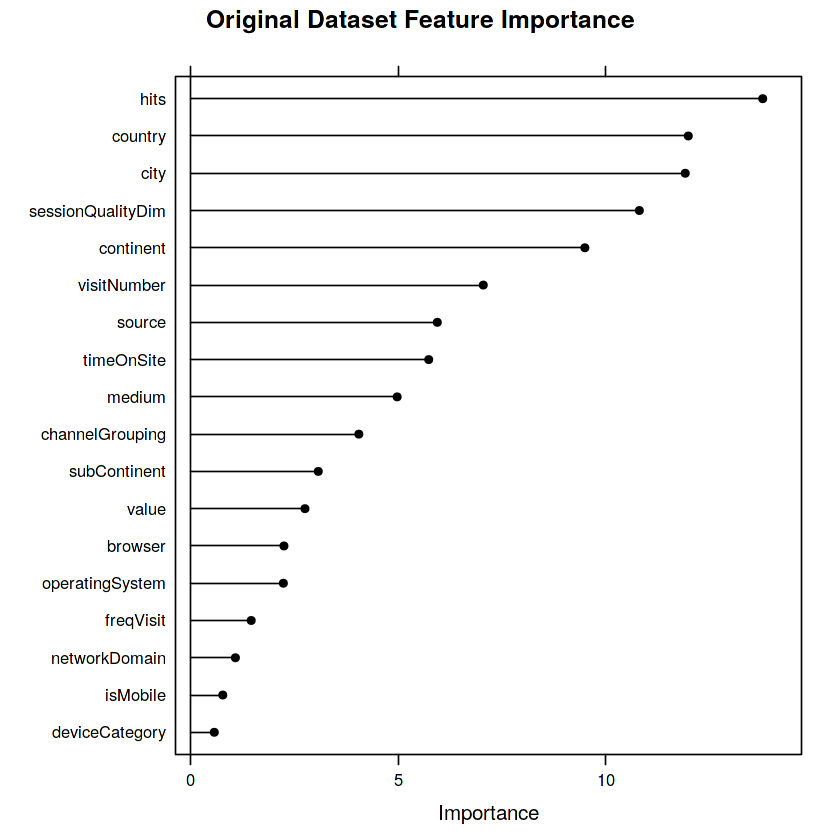

TrainAccuracy,TrainKappa,method
<dbl>,<dbl>,<chr>
0.9924024,0.7427969,custom


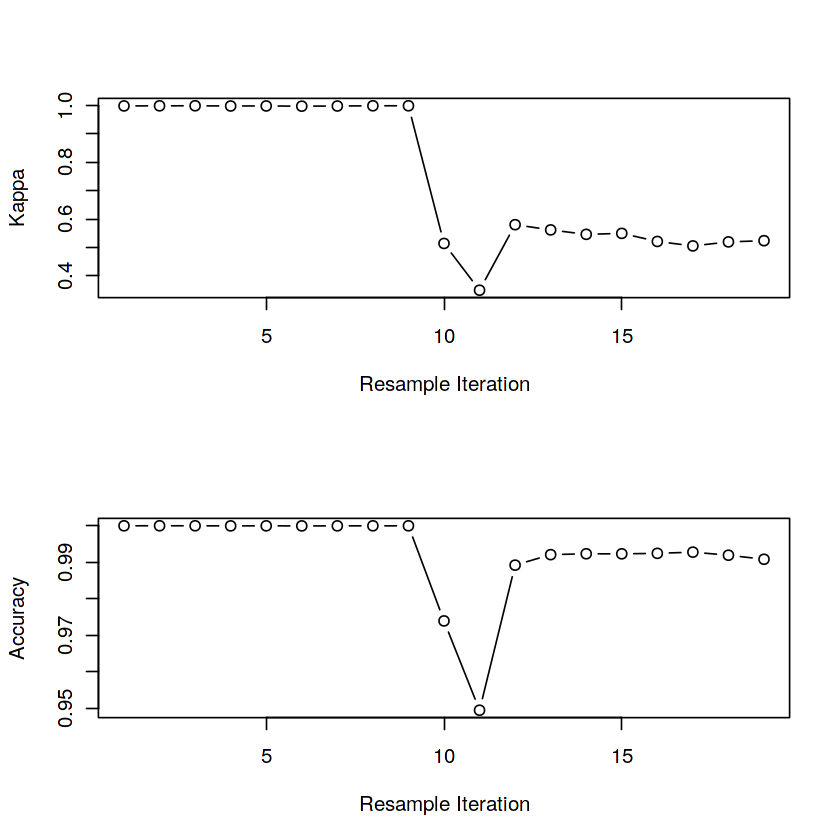

In [21]:
# original training dataset
#model <- readRDS("../input/tsmodels2020may17/original.rollingwin.AUC.rds")
#model <- readRDS("../input/tsmodelsmay21/smote.inside.kappa.catboost.rds")
model <- readRDS("../input/tsmodelsmay24/original.inside.kappa.catboost.rds")
#model
trellis.par.set(caretTheme())
plot(model)
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "Original Dataset Feature Importance")
pred <- predict(model, x_test)
confusionMatrix(pred, y_test, positive = "Rev")
#print("Original training set Confusion Matrix")
confusionMatrix(pred, y_test, positive = "Rev")
results <- confusionMatrix(pred, y_test, positive = "Rev")
#as.table(results)
#as.matrix(results)
#as.matrix(results, what = "overall")
as.matrix(results, what = "classes")
#pred <- predict(model, x_test, type="prob")
#model$resample
kappa.temp <- model$resample %>%
group_by(Resample) %>%
summarize(kappa.max = max(Kappa))
kappa.temp <- as.data.frame(kappa.temp)

acc.temp <- model$resample %>%
group_by(Resample) %>%
summarize(acc.max = max(Accuracy))
acc.temp <- as.data.frame(acc.temp)

par(mfrow = c(2, 1))
plot(kappa.temp$kappa.max, , xlab = "Resample Iteration", ylab = "Kappa", type="b")
plot(acc.temp$acc.max, , xlab = "Resample Iteration", ylab = "Accuracy", type="b")
#plot(model$resample$Kappa, type="l")
getTrainPerf(model)
#plot(model, plotType = "line", metric = model$perfNames[2], auto.key = TRUE)


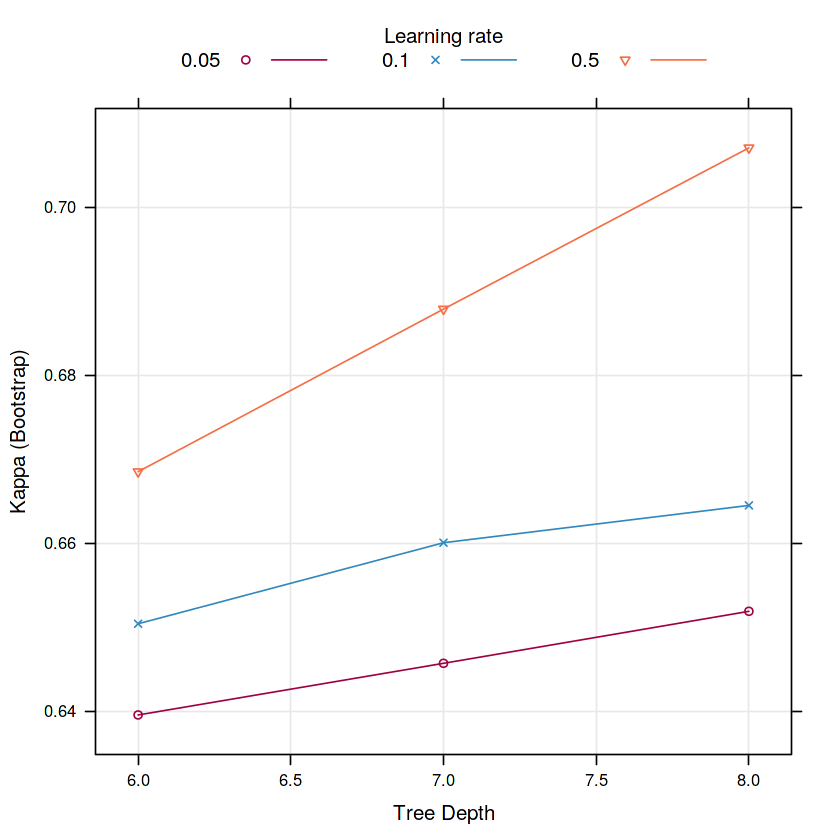

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 328787    954
     Rev    11831   3415
                                          
               Accuracy : 0.9629          
                 95% CI : (0.9623, 0.9636)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3351          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.781643        
            Specificity : 0.965266        
         Pos Pred Value : 0.223993        
         Neg Pred Value : 0.997107        
             Prevalence : 0.012664        
         Detection Rate : 0.009899        
   Detection Prevalence : 0.044193        
      Balanced Accuracy : 0.873455        
                                          
       'Positive' Class : Rev             
            

Sensitivity,0.781643397
Specificity,0.965266075
Pos Pred Value,0.223993179
Neg Pred Value,0.997106820
Precision,0.223993179
Recall,0.781643397
F1,0.348202906
Prevalence,0.012664245
Detection Rate,0.009898924
Detection Prevalence,0.044192970
Balanced Accuracy,0.873454736


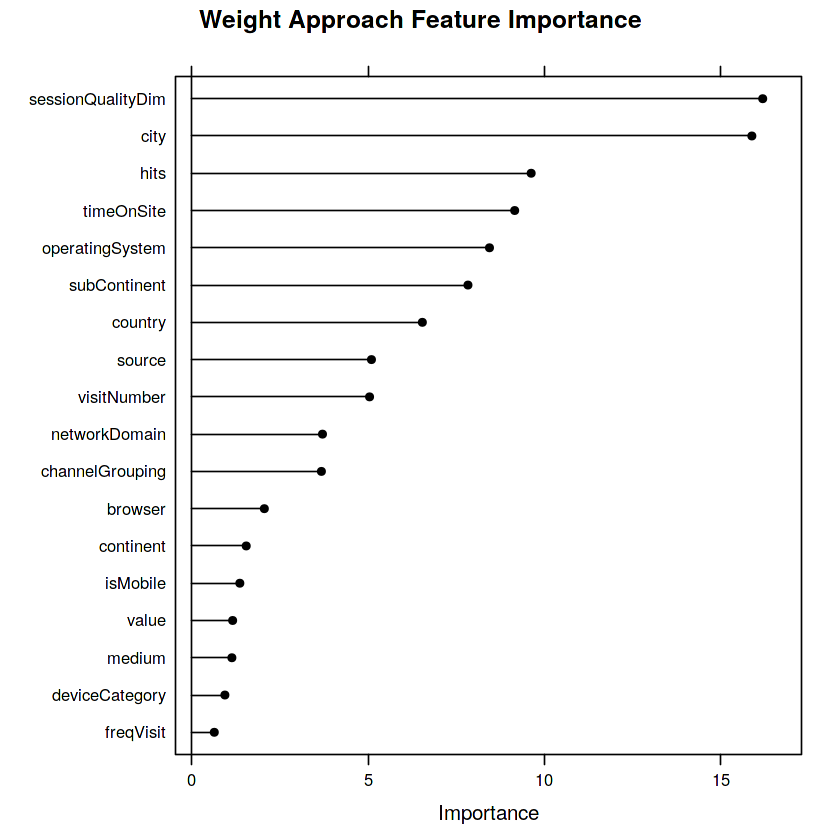

TrainAccuracy,TrainKappa,method
<dbl>,<dbl>,<chr>
0.9880732,0.7070907,custom


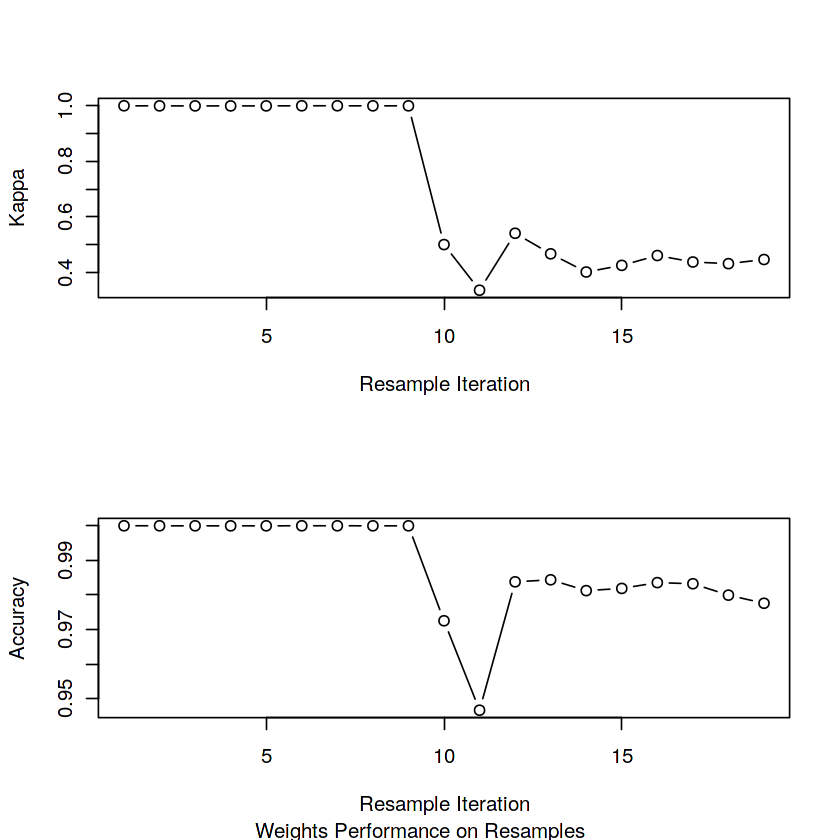

In [22]:
# weighted model
model <- readRDS("../input/tsmodelsmay24/weights.inside.kappa.catboost.rds")
trellis.par.set(caretTheme())
plot(model)
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "Weight Approach Feature Importance")
pred <- predict(model, x_test)
#print("Weighted training set Confusion Matrix")
confusionMatrix(pred, y_test, positive = "Rev")
results <- confusionMatrix(pred, y_test, positive = "Rev")
as.matrix(results, what = "classes")
#pred <- predict(model, x_test, type="prob")
#model$resample
kappa.temp <- model$resample %>%
group_by(Resample) %>%
summarize(kappa.max = max(Kappa))
kappa.temp <- as.data.frame(kappa.temp)

acc.temp <- model$resample %>%
group_by(Resample) %>%
summarize(acc.max = max(Accuracy))
acc.temp <- as.data.frame(acc.temp)

par(mfrow = c(2, 1))
plot(kappa.temp$kappa.max, , xlab = "Resample Iteration", ylab = "Kappa", type="b")
plot(acc.temp$acc.max, , xlab = "Resample Iteration", ylab = "Accuracy", type="b")
mtext("Weights Performance on Resamples", side = 3, line = -35, outer = TRUE)
#plot(model$resample$Kappa, type="l")
getTrainPerf(model)

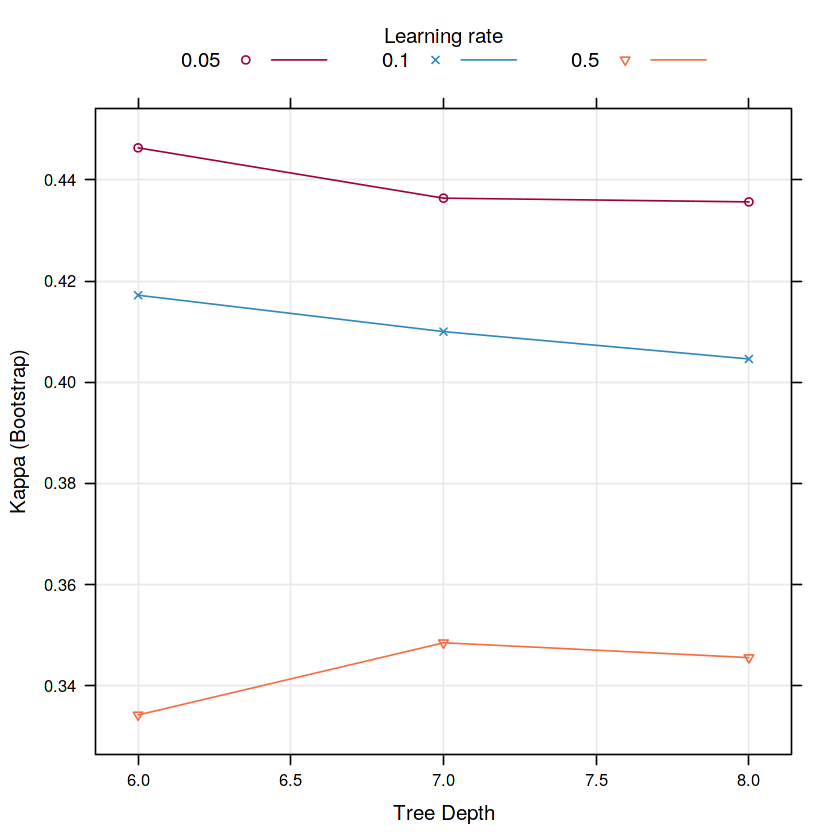

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 311110    138
     Rev    29508   4231
                                         
               Accuracy : 0.9141         
                 95% CI : (0.9131, 0.915)
    No Information Rate : 0.9873         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.2042         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.96841        
            Specificity : 0.91337        
         Pos Pred Value : 0.12540        
         Neg Pred Value : 0.99956        
             Prevalence : 0.01266        
         Detection Rate : 0.01226        
   Detection Prevalence : 0.09780        
      Balanced Accuracy : 0.94089        
                                         
       'Positive' Class : Rev            
                                

Sensitivity,0.96841382
Specificity,0.91336923
Pos Pred Value,0.12540384
Neg Pred Value,0.99955662
Precision,0.12540384
Recall,0.96841382
F1,0.22205311
Prevalence,0.01266425
Detection Rate,0.01226423
Detection Prevalence,0.09779789
Balanced Accuracy,0.94089153


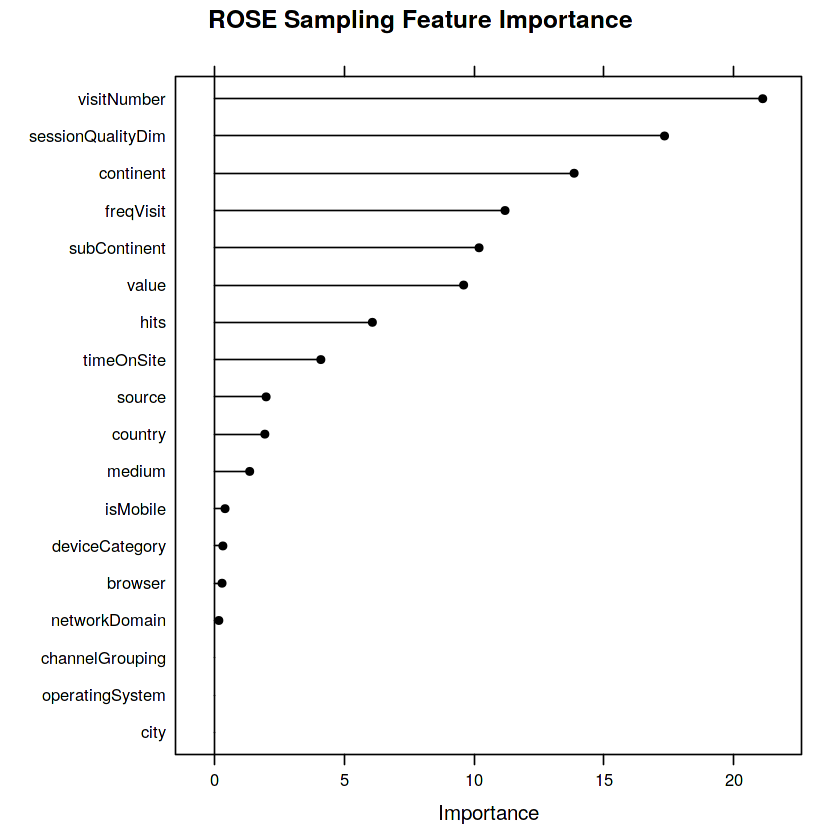

TrainAccuracy,TrainKappa,method
<dbl>,<dbl>,<chr>
0.9653502,0.4463472,custom


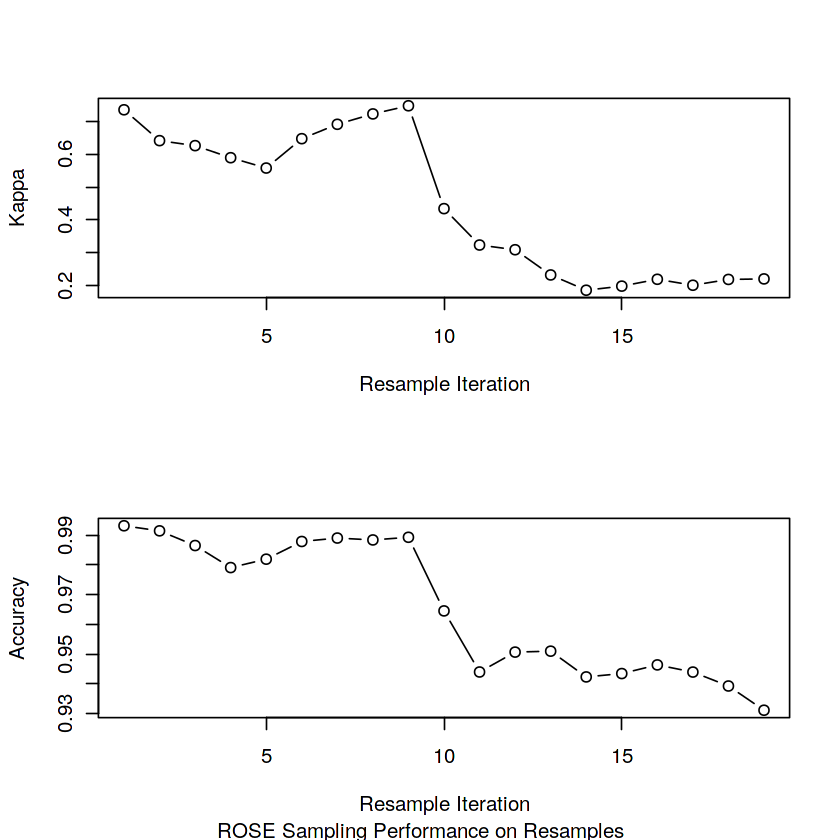

In [26]:
# ROSE sampling
model <- readRDS("../input/tsmodelsmay24/rose.inside.kappa.catboost.rds")
trellis.par.set(caretTheme())
plot(model)
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "ROSE Sampling Feature Importance")
pred <- predict(model, x_test)
#print("ROSE sampling Confusion Matrix")
confusionMatrix(pred, y_test, positive = "Rev")
results <- confusionMatrix(pred, y_test, positive = "Rev")
as.matrix(results, what = "classes")
#pred <- predict(model, x_test, type="prob")
#model$resample
kappa.temp <- model$resample %>%
group_by(Resample) %>%
summarize(kappa.max = max(Kappa))
kappa.temp <- as.data.frame(kappa.temp)

acc.temp <- model$resample %>%
group_by(Resample) %>%
summarize(acc.max = max(Accuracy))
acc.temp <- as.data.frame(acc.temp)

par(mfrow = c(2, 1))
plot(kappa.temp$kappa.max, , xlab = "Resample Iteration", ylab = "Kappa", type="b")
plot(acc.temp$acc.max, , xlab = "Resample Iteration", ylab = "Accuracy", type="b")
mtext("ROSE Sampling Performance on Resamples", side = 3, line = -35, outer = TRUE)
#plot(model$resample$Kappa, type="l")
getTrainPerf(model)


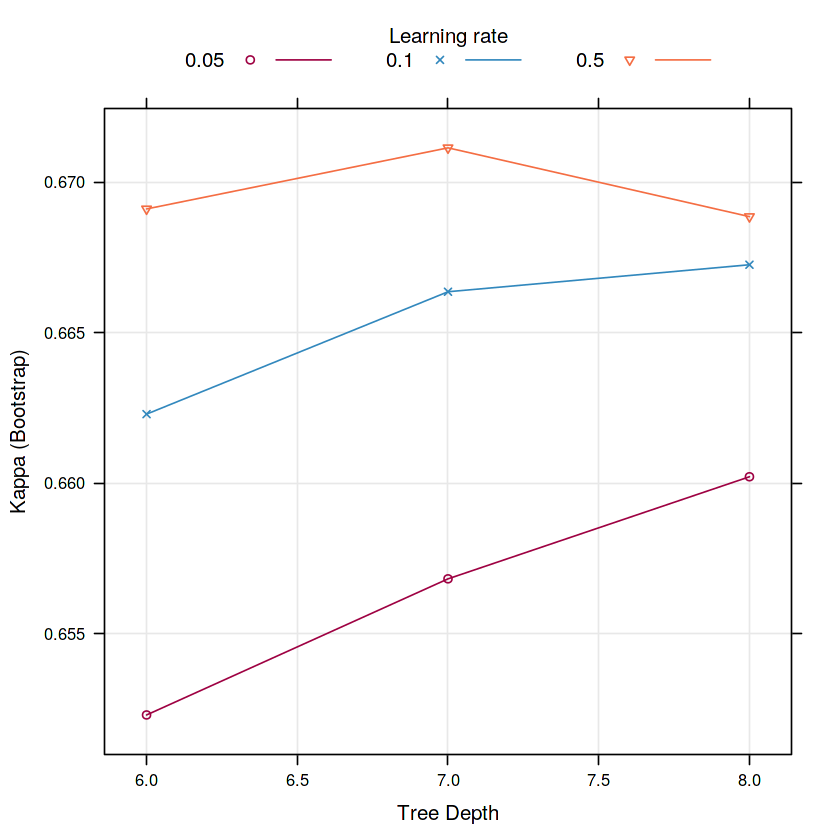

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 319408    270
     Rev    21210   4099
                                          
               Accuracy : 0.9377          
                 95% CI : (0.9369, 0.9385)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2603          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.93820         
            Specificity : 0.93773         
         Pos Pred Value : 0.16196         
         Neg Pred Value : 0.99916         
             Prevalence : 0.01266         
         Detection Rate : 0.01188         
   Detection Prevalence : 0.07336         
      Balanced Accuracy : 0.93797         
                                          
       'Positive' Class : Rev             
            

Sensitivity,0.93820096
Specificity,0.93773083
Pos Pred Value,0.16195820
Neg Pred Value,0.99915540
Precision,0.16195820
Recall,0.93820096
F1,0.27623155
Prevalence,0.01266425
Detection Rate,0.01188161
Detection Prevalence,0.07336218
Balanced Accuracy,0.93796590


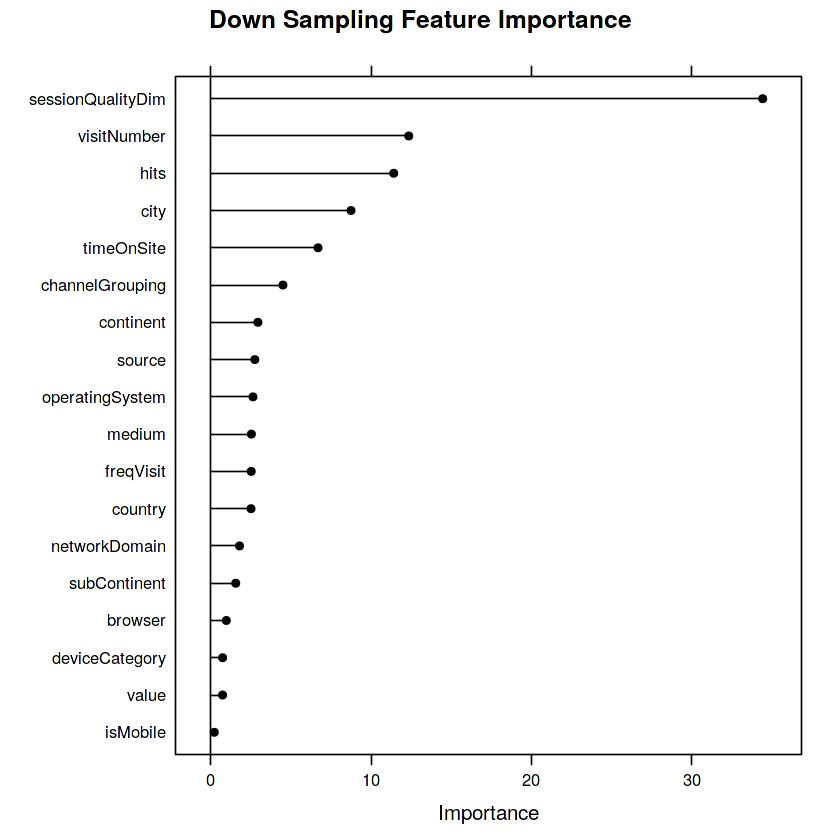

TrainAccuracy,TrainKappa,method
<dbl>,<dbl>,<chr>
0.9839869,0.6711454,custom


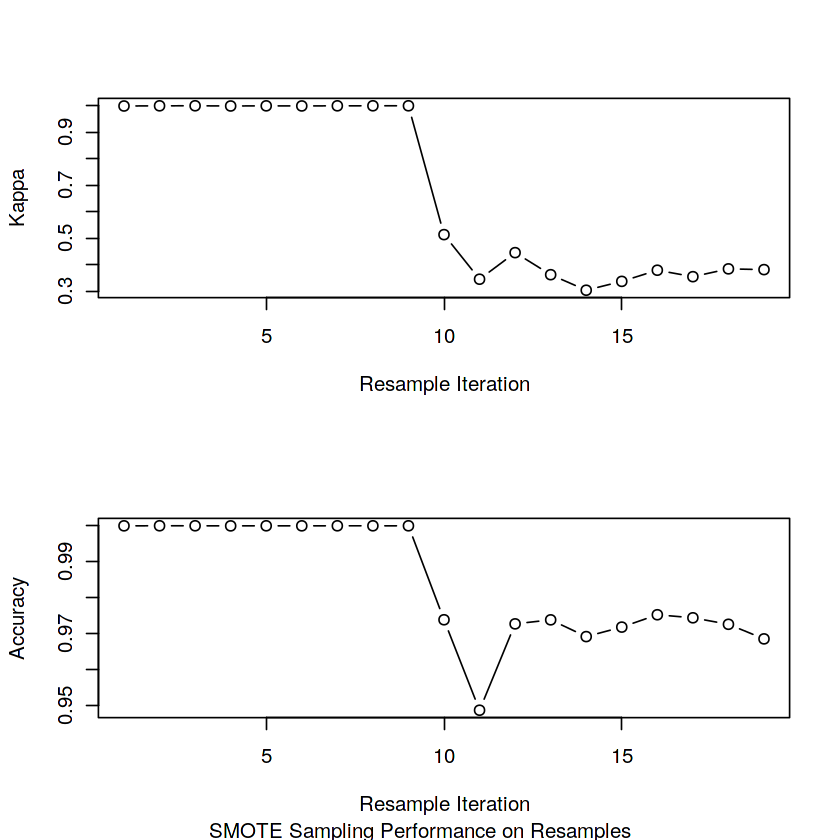

In [27]:
# SMOTE sampling
model <- readRDS("../input/tsmodelsmay24/smote.inside.kappa.catboost.rds")
#model
trellis.par.set(caretTheme())
plot(model)
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "Down Sampling Feature Importance")
pred <- predict(model, x_test)
#print("SMOTE sampling Confusion Matrix")
confusionMatrix(pred, y_test, positive = "Rev")
results <- confusionMatrix(pred, y_test, positive = "Rev")
as.matrix(results, what = "classes")
#pred <- predict(model, x_test, type="prob")
#model$resample
kappa.temp <- model$resample %>%
group_by(Resample) %>%
summarize(kappa.max = max(Kappa))
kappa.temp <- as.data.frame(kappa.temp)

acc.temp <- model$resample %>%
group_by(Resample) %>%
summarize(acc.max = max(Accuracy))
acc.temp <- as.data.frame(acc.temp)

par(mfrow = c(2, 1))
plot(kappa.temp$kappa.max, , xlab = "Resample Iteration", ylab = "Kappa", type="b")
plot(acc.temp$acc.max, , xlab = "Resample Iteration", ylab = "Accuracy", type="b")
mtext("SMOTE Sampling Performance on Resamples", side = 3, line = -35, outer = TRUE)
#plot(model$resample$Kappa, type="l")
getTrainPerf(model)


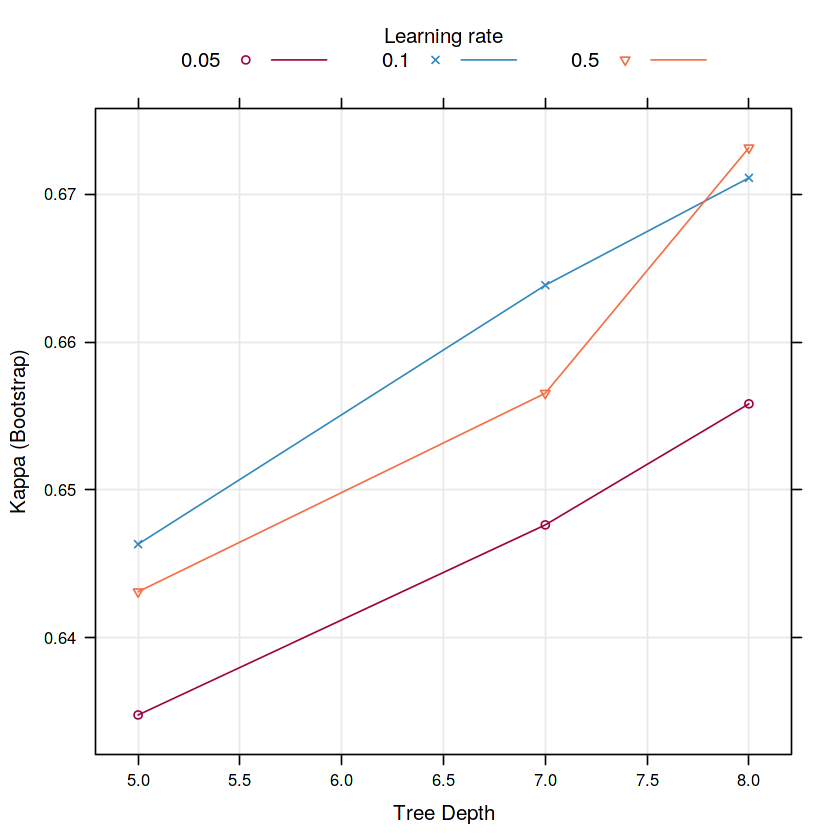

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 335792   2460
     Rev     4826   1909
                                          
               Accuracy : 0.9789          
                 95% CI : (0.9784, 0.9794)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3336          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.436942        
            Specificity : 0.985832        
         Pos Pred Value : 0.283445        
         Neg Pred Value : 0.992727        
             Prevalence : 0.012664        
         Detection Rate : 0.005534        
   Detection Prevalence : 0.019522        
      Balanced Accuracy : 0.711387        
                                          
       'Positive' Class : Rev             
            

Sensitivity,0.436942092
Specificity,0.985831635
Pos Pred Value,0.283444692
Neg Pred Value,0.992727316
Precision,0.283444692
Recall,0.436942092
F1,0.343840058
Prevalence,0.012664245
Detection Rate,0.005533542
Detection Prevalence,0.019522475
Balanced Accuracy,0.711386864


Accuracy,Kappa,depth,learning_rate,l2_leaf_reg,rsm,border_count,iterations,Resample
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.9999934,0.9996567,5,0.05,3,0.8,255,200,Resample01
0.9999934,0.9996567,5,0.10,3,0.8,255,200,Resample01
0.9999736,0.9986261,5,0.50,3,0.8,255,200,Resample01
0.9999934,0.9996567,7,0.05,3,0.8,255,200,Resample01
0.9999868,0.9993135,7,0.10,3,0.8,255,200,Resample01
0.9999604,0.9979392,7,0.50,3,0.8,255,200,Resample01
0.9999868,0.9993131,8,0.05,3,0.8,255,200,Resample01
0.9999868,0.9993131,8,0.10,3,0.8,255,200,Resample01
0.9999670,0.9982833,8,0.50,3,0.8,255,200,Resample01


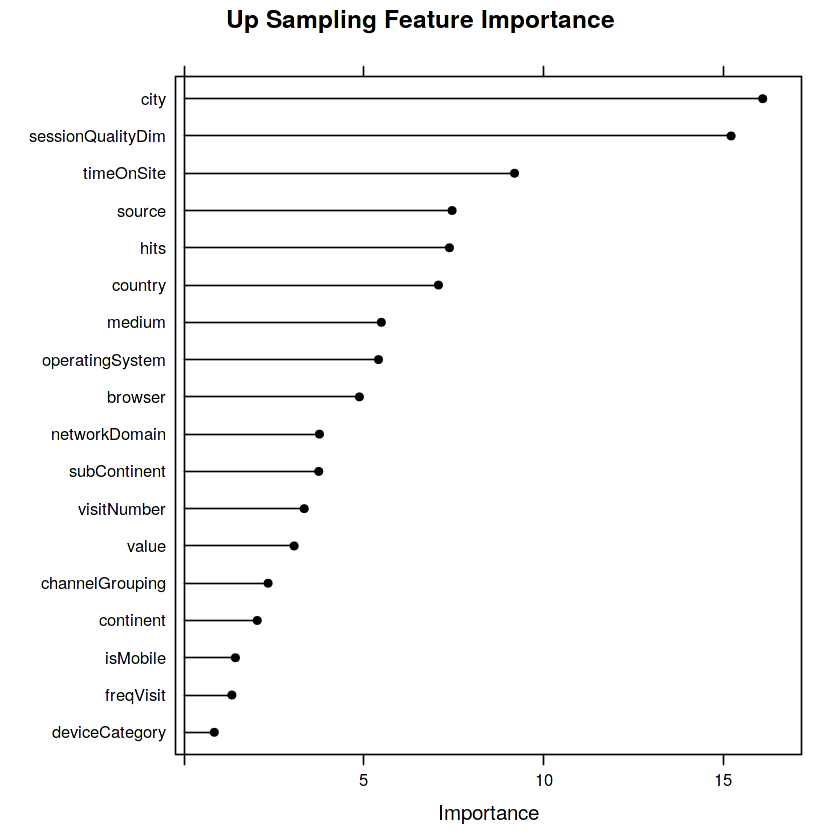

TrainAccuracy,TrainKappa,method
<dbl>,<dbl>,<chr>
0.9828503,0.6731318,custom


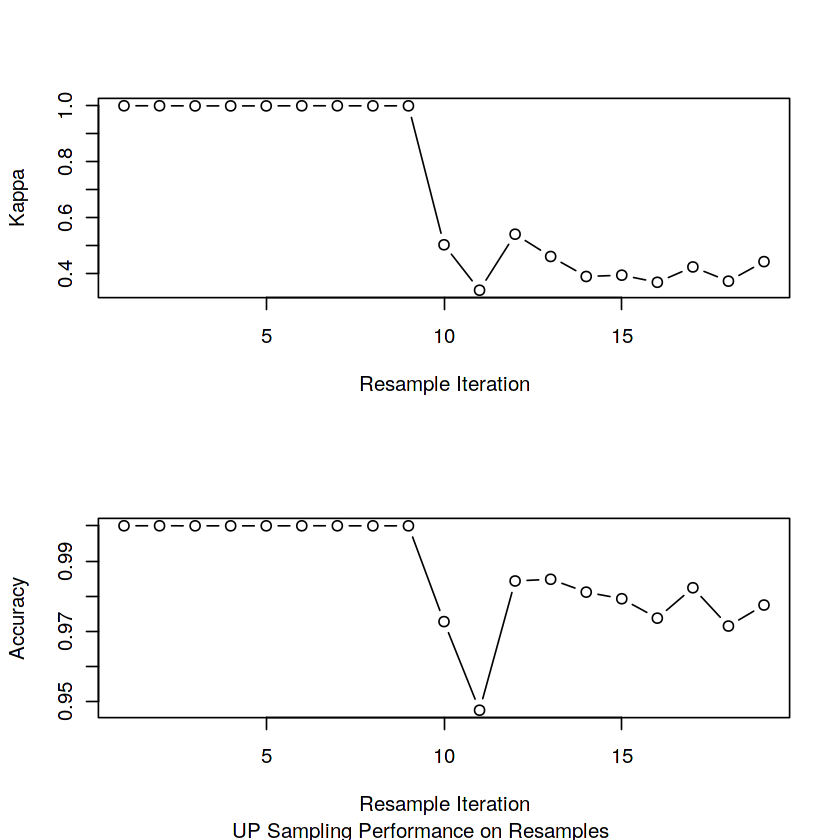

In [28]:
# UP sampling
model <- readRDS("../input/tsmodelsmay24/up2.inside.kappa.catboost.rds")
trellis.par.set(caretTheme())
plot(model)
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "Up Sampling Feature Importance")
pred <- predict(model, x_test)
#print("UP sampling Confusion Matrix")
confusionMatrix(pred, y_test, positive = "Rev")
results <- confusionMatrix(pred, y_test, positive = "Rev")
as.matrix(results, what = "classes")
#pred <- predict(model, x_test, type="prob")
model$resample
kappa.temp <- model$resample %>%
group_by(Resample) %>%
summarize(kappa.max = max(Kappa))
kappa.temp <- as.data.frame(kappa.temp)

acc.temp <- model$resample %>%
group_by(Resample) %>%
summarize(acc.max = max(Accuracy))
acc.temp <- as.data.frame(acc.temp)

par(mfrow = c(2, 1))
plot(kappa.temp$kappa.max, , xlab = "Resample Iteration", ylab = "Kappa", type="b")
plot(acc.temp$acc.max, , xlab = "Resample Iteration", ylab = "Accuracy", type="b")
mtext("UP Sampling Performance on Resamples", side = 3, line = -35, outer = TRUE)
#plot(model$resample$Kappa, type="l")
getTrainPerf(model)


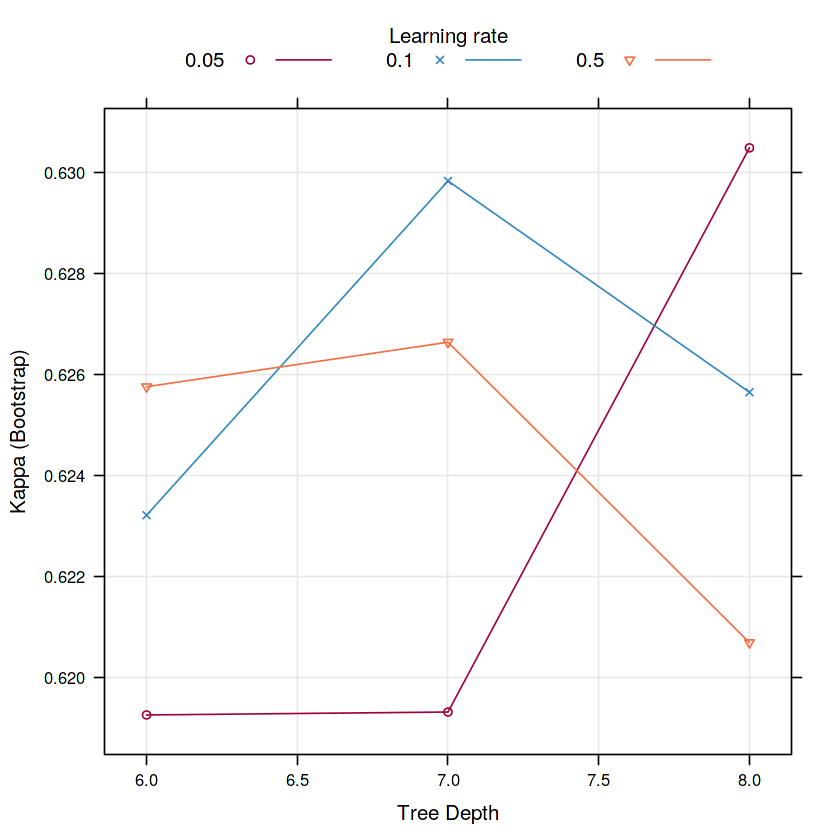

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 316370    140
     Rev    24248   4229
                                          
               Accuracy : 0.9293          
                 95% CI : (0.9284, 0.9302)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2408          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.96796         
            Specificity : 0.92881         
         Pos Pred Value : 0.14851         
         Neg Pred Value : 0.99956         
             Prevalence : 0.01266         
         Detection Rate : 0.01226         
   Detection Prevalence : 0.08255         
      Balanced Accuracy : 0.94838         
                                          
       'Positive' Class : Rev             
            

Sensitivity,0.96795605
Specificity,0.92881175
Pos Pred Value,0.14850581
Neg Pred Value,0.99955768
Precision,0.14850581
Recall,0.96795605
F1,0.25750472
Prevalence,0.01266425
Detection Rate,0.01225843
Detection Prevalence,0.08254514
Balanced Accuracy,0.94838390


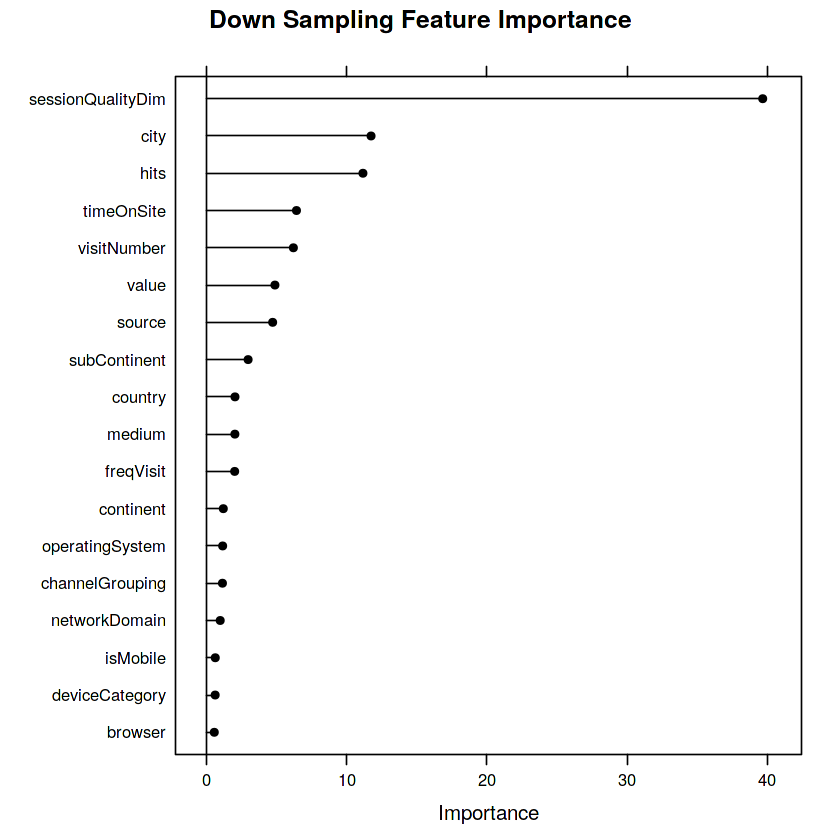

TrainAccuracy,TrainKappa,method
<dbl>,<dbl>,<chr>
0.9773475,0.6304913,custom


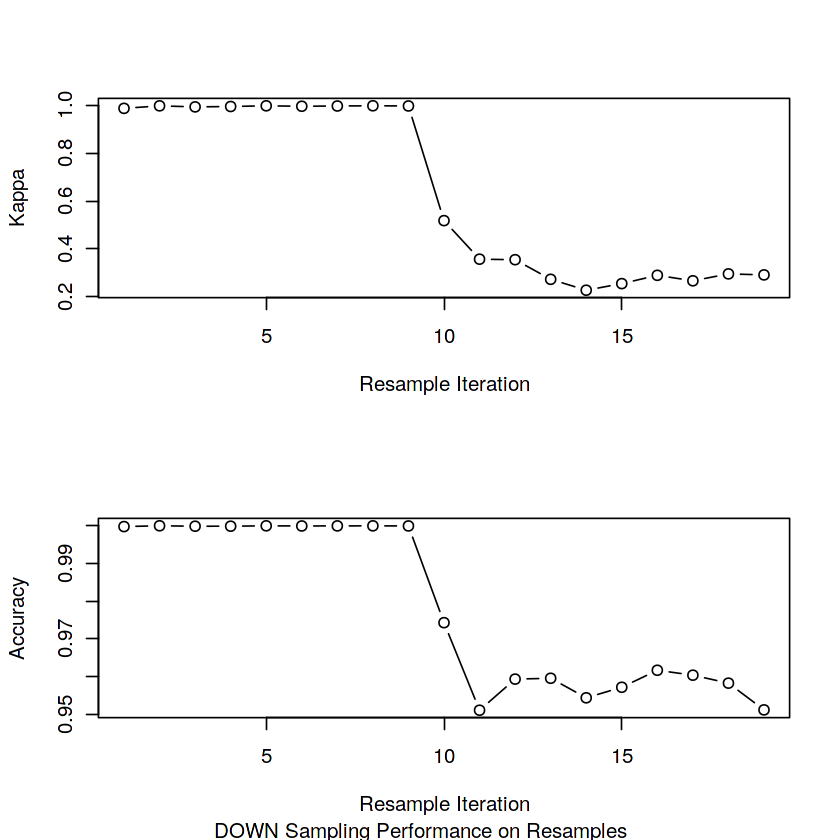

In [32]:
# DOWN sampling
model <- readRDS("../input/tsmodelnew/down.inside.kappa.catboost.rds")
trellis.par.set(caretTheme())
plot(model)
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "Down Sampling Feature Importance")
pred <- predict(model, x_test)
#print("DOWN sampling Confusion Matrix")
confusionMatrix(pred, y_test, positive = "Rev")
results <- confusionMatrix(pred, y_test, positive = "Rev")
as.matrix(results, what = "classes")
#pred <- predict(model, x_test, type="prob")
#model$resample
kappa.temp <- model$resample %>%
group_by(Resample) %>%
summarize(kappa.max = max(Kappa))
kappa.temp <- as.data.frame(kappa.temp)

acc.temp <- model$resample %>%
group_by(Resample) %>%
summarize(acc.max = max(Accuracy))
acc.temp <- as.data.frame(acc.temp)

par(mfrow = c(2, 1))
plot(kappa.temp$kappa.max, , xlab = "Resample Iteration", ylab = "Kappa", type="b")
plot(acc.temp$acc.max, , xlab = "Resample Iteration", ylab = "Accuracy", type="b")
mtext("DOWN Sampling Performance on Resamples", side = 3, line = -35, outer = TRUE)
#plot(model$resample$Kappa, type="l")
getTrainPerf(model)

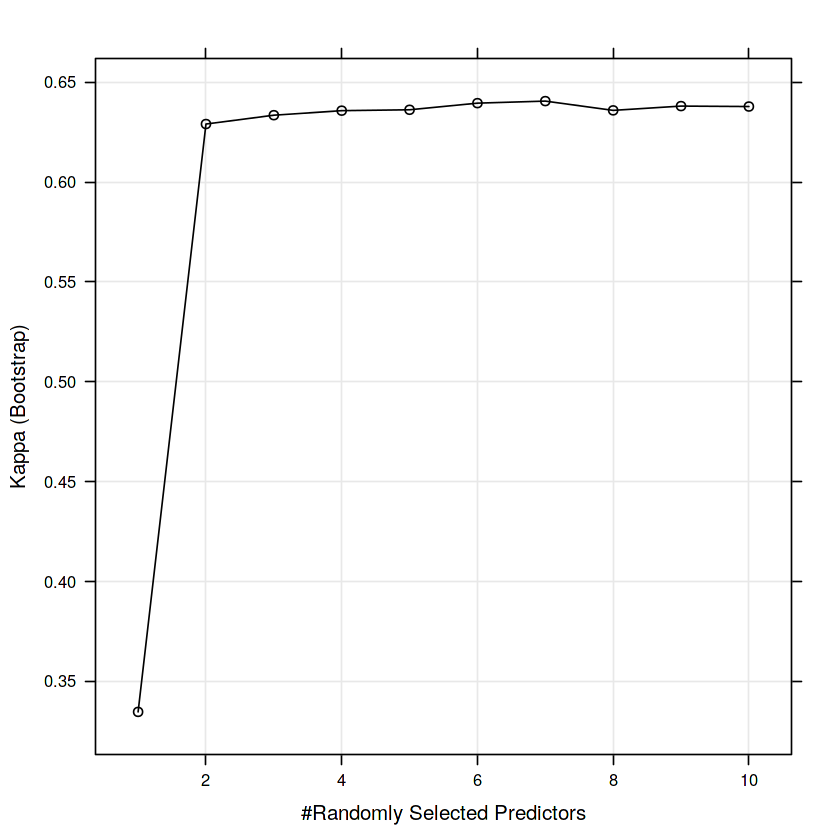

Sensitivity,0.97390707
Specificity,0.91868016
Pos Pred Value,0.13316017
Neg Pred Value,0.99963582
Precision,0.13316017
Recall,0.97390707
F1,0.23428682
Prevalence,0.01266425
Detection Rate,0.01233380
Detection Prevalence,0.09262378
Balanced Accuracy,0.94629362


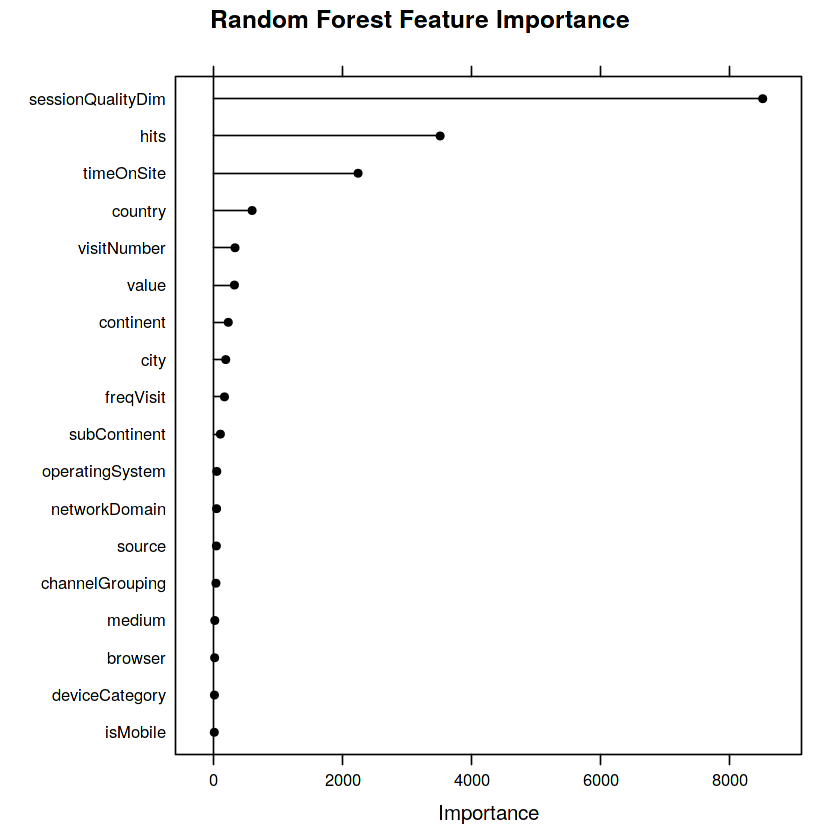

TrainAccuracy,TrainKappa,method
<dbl>,<dbl>,<chr>
0.9772566,0.6405428,rf


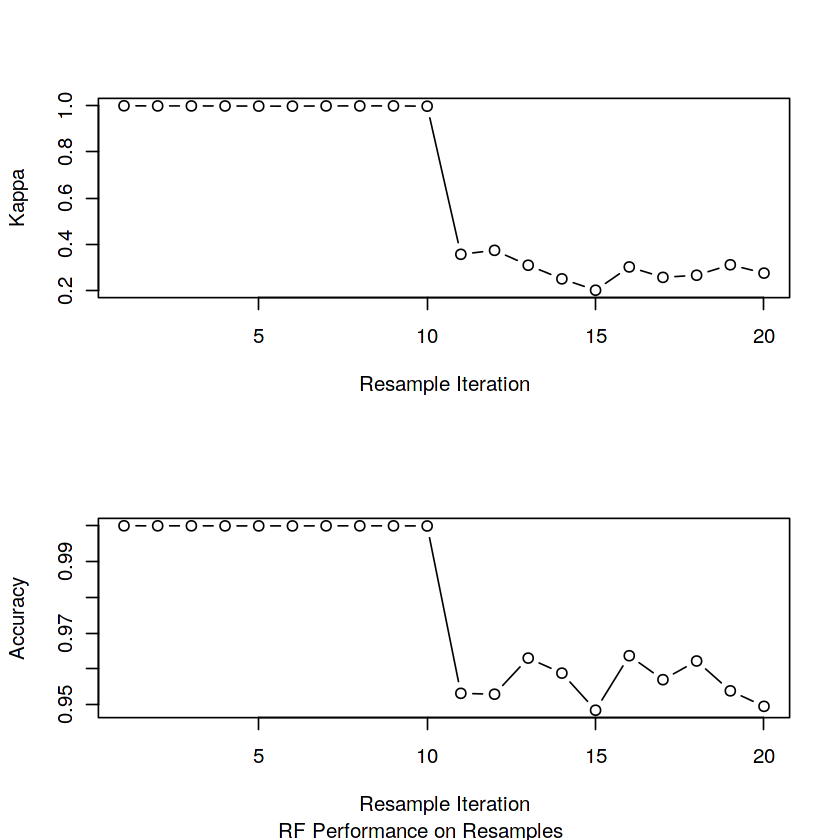

In [33]:
# Random Forest
model <- readRDS("../input/tsmodelsmay24/rf.model.rds")
trellis.par.set(caretTheme())
plot(model)
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "Random Forest Feature Importance")
pred <- predict(model, x_test)
#print("RF Confusion Matrix")
results <- confusionMatrix(pred, y_test, positive = "Rev")
as.matrix(results, what = "classes")
#pred <- predict(model, x_test, type="prob")
#model$resample
kappa.temp <- model$resample %>%
group_by(Resample) %>%
summarize(kappa.max = max(Kappa))
kappa.temp <- as.data.frame(kappa.temp)

acc.temp <- model$resample %>%
group_by(Resample) %>%
summarize(acc.max = max(Accuracy))
acc.temp <- as.data.frame(acc.temp)

par(mfrow = c(2, 1))
plot(kappa.temp$kappa.max, , xlab = "Resample Iteration", ylab = "Kappa", type="b")
plot(acc.temp$acc.max, , xlab = "Resample Iteration", ylab = "Accuracy", type="b")
mtext("RF Performance on Resamples", side = 3, line = -35, outer = TRUE)
#plot(model$resample$Kappa, type="l")
getTrainPerf(model)

In [ ]:
# xgboost classification
xgb.model <- readRDS("../input/tsmodels2020may17/xgb.rds")
xgb.model
catImp <- varImp(xgb.model, scale = FALSE, main = "xgboost Attribute Importance")
plot(catImp, top = 18)
x_test.xgb = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate))))
y_test.xgb = test.data$totalTransactionRevenue
xgb.pred <- predict(xgb.model, x_test.xgb)
print("xgboost Confusion Matrix")
confusionMatrix(xgb.pred, y_test.xgb, positive = "Rev")
xgb.pred <- predict(xgb.model, x_test.xgb, type="prob")

In [ ]:
# split test data and run the model on each subset
#---------------------------------
s.model <- readRDS("../input/tsmodels2020may18/smote.seed.catboost.rds")
s.pred <- predict(s.model, x_test)
print("training dataset...")
confusionMatrix(s.pred, y_test, positive = "Rev")
#str(test.data)
group.test.data <- split(test.data, sample(1:10, nrow(test.data), replace=T))

for (i in 1:length(group.test.data)){
    print(i)
    sub.test <- as.data.frame(group.test.data[i], col.names = names(c("channelGrouping", "browser", "operatingSystem",
                                                        "deviceCategory", "isMobile", "continent", "subContinent",
                                                        "country", "city", "networkDomain", "source", "medium",
                                                        "value", "visitNumber", "hits", "sessionQualityDim",
                                                        "timeOnSite", "totalTransactionRevenue", "ldate",
                                                        "freqVisit")))

    y_sub.test <- unlist(sub.test[c('totalTransactionRevenue')])
    x_sub.test <- select(sub.test, -c("totalTransactionRevenue"))
    pred <- predict(model, x_sub.test)
    print(confusionMatrix(pred, y_sub.test, positive = "Rev"))
}


In [36]:
# Recursive Feature Elimination along with RF
rf_fit <- function(x, y, first, last, ...){
loadNamespace("randomForest")

df_down <- caret::downSample(x, y)

randomForest::randomForest(
select(df_down, -Class),
df_down$Class,
importance = (first | last),
...)
}

new_rf <- rfFuncs

#new_rf$summary <- rf_stats
new_rf$fit <- rf_fit
# check this one run it with undersampling
# backwards selection, recursive feature elimination (RFE) using caret
str(training)
subsets <- c(5, 10, 12, 15, 18)
#model_weights <- ifelse(training$totalTransactionRevenue == "noRev",
#                        (1/table(training$totalTransactionRevenue)[1]) * 0.5,
#                        (1/table(training$totalTransactionRevenue)[2]) * 0.5)
set.seed(10)

ctrl <- rfeControl(#functions = rfFuncs,
                   functions = new_rf,
                   #method = "timeslice",
                   index = function_ts(time.series.slices$train, temp),
                   returnResamp = "all",
                   indexOut = function_ts(time.series.slices$test, temp))

rfe.model <- rfe(x_train[, !(colnames(x_train) %in% c("ldate"))], training$totalTransactionRevenue,
                 sizes = subsets,
                 metric = "Kappa",
                 #weights = model_weights,
                 rfeControl = ctrl)

saveRDS(rfe.model, "rfe.model.rds")

model <- readRDS("../input/tsmodelsmay24/rfe.model.rds")
model 
predictors(model)
model$fit
pred <- predict(model$fit, x_test)
#table(s.pred)
confusionMatrix(pred, y_test)


Recursive feature selection

Outer resampling method: Bootstrapped (19 reps) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.9761 0.6223    0.02359  0.3613         
        10   0.9765 0.6285    0.02341  0.3655        *
        12   0.9761 0.6272    0.02385  0.3668         
        15   0.9759 0.6261    0.02404  0.3679         
        18   0.9760 0.6272    0.02400  0.3671         

The top 5 variables (out of 10):
   sessionQualityDim, visitNumber, timeOnSite, city, freqVisit


[1] "sessionQualityDim" "visitNumber"       "timeOnSite"       
 [4] "city"              "freqVisit"         "hits"             
 [7] "country"           "source"            "value"            
[10] "networkDomain"


Call:
 randomForest(x = select(df_down, -Class), y = df_down$Class,      importance = (first | last)) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 1.54%
Confusion matrix:
      noRev   Rev class.error
noRev 16155   339  0.02055293
Rev     170 16324  0.01030678

Confusion Matrix and Statistics

          Reference
Prediction  noRev    Rev
     noRev 315295    140
     Rev    25323   4229
                                          
               Accuracy : 0.9262          
                 95% CI : (0.9253, 0.9271)
    No Information Rate : 0.9873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2324          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9257          
            Specificity : 0.9680          
         Pos Pred Value : 0.9996          
         Neg Pred Value : 0.1431          
             Prevalence : 0.9873          
         Detection Rate : 0.9139          
   Detection Prevalence : 0.9143          
      Balanced Accuracy : 0.9468          
                                          
       'Positive' Class : noRev           
            

In [ ]:
# binarizing, descritizing
imbal.data <- rbind(temp1.imbal.data, temp2.imbal.data)
str(imbal.data)
imbal.data <- imbal.data[which(imbal.data$totalTransactionRevenue != 0),] 
#--------------------------------------------------
cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value",
             "month", "wday", "mday")

imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
imbal.data <- select(imbal.data, -c(fullVisitorId, mday, wday, month, pageviews))
#----------------------------------------------------
# Categorical attributes level reduction...
cols.nam <- c("networkDomain")
catTofac <- function(x, df){
    for (i in 1:length(x)){
        df[,x[i]] <- fct_lump(df[,x[i]], n = 20, w = NULL, other_level = "(Other)")
    }
    return(df)
}
imbal.data <- catTofac(cols.nam, imbal.data)
#-----------------------------------------
print("Normalizing the training set...")
cols.nam <- c("visitNumber", "hits", "timeOnSite", "sessionQualityDim", "freqVisit")

pp_norm <- preProcess(imbal.data[cols.nam], 
                      method = c("scale", "center"))
                      #method = c("range"))
imbal.data[cols.nam] <- predict(pp_norm, newdata = imbal.data[cols.nam])
#-------------------------------------  
#cut(training$totalTransactionRevenue,breaks=c(-Inf,2,3, Inf), labels = c("<2", "2-3", ">3"))
#training$totalTransactionRevenue <- cut(training$totalTransactionRevenue,breaks=c(-Inf, median(training$totalTransactionRevenue), Inf), labels = c("low", "high"))
# Binarizing
imbal.data$totalTransactionRevenue <- cut(imbal.data$totalTransactionRevenue,breaks=c(-Inf, median(imbal.data$totalTransactionRevenue), Inf), labels = c("low", "high"))
table(imbal.data$totalTransactionRevenue)            
# descritizing
rev.quantile <- quantile(imbal.data$totalTransactionRevenue,  probs = c(20, 40, 60, 80)/100)
rev.quantile              
imbal.data$totalTransactionRevenue <- cut(imbal.data$totalTransactionRevenue,breaks=c(-Inf, rev.quantile, Inf), labels = c("lowest", "low", "medium", "high", "highest"))#1,2,3,4,5
table(imbal.data$totalTransactionRevenue)
#-------------------------------------
str(imbal.data)
test.data <- imbal.data %>%
    filter(ldate >= as.Date("2018-05-01"))
training <- imbal.data %>%
    filter(ldate < as.Date("2018-05-01"))
#-------------------------------------
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
                  "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("visitNumber", "hits", "sessionQualityDim", 
                                 "timeOnSite", "totalTransactionRevenue", "ldate", "freqVisit")])
    return(df)
}
training <- cat.encode.func(training)
test.data <- cat.encode.func(test.data)
#--------------------------------------
training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
# Renaming levels for classProbs = TRUE in TrainControl                  
#levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
y_train <- unlist(training[c('totalTransactionRevenue')])
#label_values <- as.integer(c("1","2","3","4","5"))
x_train <- select(training, -c("totalTransactionRevenue"))

#levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
str(y_test)
str(y_train)
#-------------------------------------
# Preparing dataset for timeSlices
temp <- x_train %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
print("Creating time slices for time series cross validation...")
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 2, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}   
#-------------------------------------------
set.seed(123)                   
fitControl <- trainControl(#method = "timeslice",
                           #classProbs = TRUE,
                           #sampling = "smote",
                           #summaryFunction = twoClassSummary,
                           #summaryFunction = prSummary,
                           #savePredictions = TRUE,
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)
                           #indexFinal = unlist(indexFinal)
)

# Grid Search for tuning the parameters
catboost.grid <- expand.grid(depth = c(5, 6, 7),#unbal:5, c(5, 7), #c(5,6,7),7
                    learning_rate = c(0.05, 0.1, 0.2), #c(0.5,0.1,0.05),0.5
                    iterations = 200,#200, c(100,200), #c(50,100,200),200
                    l2_leaf_reg = 3,#1e-06
                    rsm = 0.8, #c(0.8,1.0),0.8
                    #class_weights <- c(0.1, 4) # when feeding imbalanced class?
                    border_count = c(64, 128, 255))#255, c(64,128,255)) 255
print("Model fitting...")
model <- train(x = x_train[, !(colnames(x_train) %in% c("ldate"))], 
               #data = training[, !(colnames(training) %in% c("ldate"))],
               y = y_train,
               #label = label_values,
               method = catboost.caret,
               #loss_function="MultiClass",
               #method = "gbm",
               #weights = model_weights,
               trControl = fitControl,
               tuneGrid = catboost.grid,
               #tuneLength = 3,
               #metric = "AUC",
               #metric = "F", 
               task_type = "CPU",# performance settings
               thread_count = 4 # thread_count equal to the number of cpu cores which is 4  
              )

saveRDS(model, "desc.catboost.rds")

# features same as smote.catboost, etc, no date data e.g., month, mday, no pageviews, freqVisit included 

In [ ]:
#bi.model <- readRDS("../input/bidesctsmodels/bi.catboost.rds") 
model <- readRDS("../input/bidiscmodels/desc.catboost.rds") 
table(imbal.data$totalTransactionRevenue) 
model 
pred <- predict(model, x_test)
#table(s.pred)
confusionMatrix(pred, y_test)
#-------------------------
model <- readRDS("../input/tsmodelsmay24/rf.model.rds")
trellis.par.set(caretTheme())
plot(model)
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "Discretizing Feature Importance")
pred <- predict(model, x_test)
#print("Original training set Confusion Matrix")
results <- confusionMatrix(pred, y_test)
as.matrix(results, what = "classes")
#pred <- predict(model, x_test, type="prob")
model$resample
kappa.temp <- model$resample %>%
group_by(Resample) %>%
summarize(kappa.max = max(Kappa))
kappa.temp <- as.data.frame(kappa.temp)

acc.temp <- model$resample %>%
group_by(Resample) %>%
summarize(acc.max = max(Accuracy))
acc.temp <- as.data.frame(acc.temp)

par(mfrow = c(2, 1))
plot(kappa.temp$kappa.max, , xlab = "Resample Iteration", ylab = "Kappa", type="b")
plot(acc.temp$acc.max, , xlab = "Resample Iteration", ylab = "Accuracy", type="b")

#plot(model$resample$Kappa, type="l")
getTrainPerf(model)

In [ ]:
model 
pred <- predict(model, x_test)
#table(s.pred)
confusionMatrix(pred, y_test, positive = "high")
#-------------------------
model <- readRDS("../input/tsmodelsmay24/rf.model.rds")
trellis.par.set(caretTheme())
plot(model)
catImp <- varImp(model, scale = FALSE)
plot(catImp, top = 18, main = "Binarizing Feature Importance")
pred <- predict(model, x_test)
#print("Original training set Confusion Matrix")
results <- confusionMatrix(pred, y_test, positive = "high")
as.matrix(results, what = "classes")
#pred <- predict(model, x_test, type="prob")
model$resample
kappa.temp <- model$resample %>%
group_by(Resample) %>%
summarize(kappa.max = max(Kappa))
kappa.temp <- as.data.frame(kappa.temp)

acc.temp <- model$resample %>%
group_by(Resample) %>%
summarize(acc.max = max(Accuracy))
acc.temp <- as.data.frame(acc.temp)

par(mfrow = c(2, 1))
plot(kappa.temp$kappa.max, , xlab = "Resample Iteration", ylab = "Kappa", type="b")
plot(acc.temp$acc.max, , xlab = "Resample Iteration", ylab = "Accuracy", type="b")

#plot(model$resample$Kappa, type="l")
getTrainPerf(model)

In [ ]:
# descritizing
#model <- readRDS("../input/bidesctsmodels/desc.catboost.rds") 
rev.quantile              
table(imbal.data$totalTransactionRevenue)
model
pred <- predict(model, x_test)
#table(s.pred)
confusionMatrix(pred, y_test)

In [ ]:
# Classification using xgboost
#----------------------------------
#----------------------------------
#str(training)
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
                  "continent","subContinent","country", "city", "networkDomain", 
                  "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("visitNumber", "hits", "freqVisit", "sessionQualityDim", 
                                 "timeOnSite", "totalTransactionRevenue", "ldate")])
    return(df)
}
training <- cat.encode.func(training)
test.data <- cat.encode.func(test.data)

# almost 80% for training and 20% for testing
#dim(training)
#dim(test.data)
# Preparing dataset for timeSlices
temp <- x_train %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
print("Creating time slices for time series cross validation...")
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 2, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}   
levels(training$totalTransactionRevenue) <- c("noRev", "Rev")
x_train = xgb.DMatrix(as.matrix(training %>% select(-c(totalTransactionRevenue, ldate))))
y_train = training$totalTransactionRevenue
levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
x_test = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate))))
y_test = test.data$totalTransactionRevenue
#str(x_train)
xgb_trcontrol = trainControl(
  #method = "timeslice",
  classProbs = TRUE,
  #summaryFunction = prSummary,
  #savePredictions = TRUE,
  index = function_ts(time.series.slices$train, temp),
  indexOut = function_ts(time.series.slices$test, temp),
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE,
  returnResamp = "all",
  sampling = "down"
)
xgbGrid <- expand.grid(nrounds = 100,#c(100,200),  # this is n_estimators in the python code
                       max_depth = c(5, 6, 7),#c(10, 15, 20, 25), 7
                       colsample_bytree = c(0.5, 1),#seq(0.5, 0.9, length.out = 5),
                       ## The values below are default values in the sklearn-api. 
                       eta = c(0.01, 0.2),#0.2, 0.1
                       gamma=0,
                       min_child_weight = 1,
                       subsample = 0.5
                      )
# More classification models are being generated: 
# fixed vs rolling window, original, weighted and sampled datasets
print("XGBoost Model fitting...")
set.seed(456) 
xgb.model = train(
  x_train, y_train,  
  trControl = xgb_trcontrol,
  tuneGrid = xgbGrid,
  #tuneLength = 2,
  method = "xgbTree",
  metric = "Kappa",
  nthread = 4  
)
saveRDS(xgb.model, "xgboost.rds")

In [ ]:
xgb.model <- readRDS("../input/tsmodelxgb/xgb.rds")
x_test.xgb = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate, fullVisitorId))))
y_test.xgb = test.data$totalTransactionRevenue
xgb.pred <- predict(xgb.model, x_test.xgb)
#table(s.pred)
confusionMatrix(xgb.pred, y_test.xgb, positive = "Rev")
xgb.pred <- predict(xgb.model, x_test.xgb, type="prob")
#sum((xgb.pred$Rev > 0.9) == TRUE)

In [ ]:
# Random forest
set.seed(123)
training$ldate <- as.numeric(training$ldate)

#smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 4500, perc.under=200)
#smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 6500, perc.under=136)
smote.train <- SMOTE(totalTransactionRevenue ~ ., data  = training, perc.over = 6000, perc.under=150)
smote.train$ldate <- lubridate::as_datetime(smote.train$ldate)
table(training$totalTransactionRevenue)
table(smote.train$totalTransactionRevenue)
print(prop.table(table(training$totalTransactionRevenue)))
print(prop.table(table(smote.train$totalTransactionRevenue)))
#----------------------------------
set.seed(1560)
training$ldate <- as.numeric(training$ldate)
ovun.train <- ovun.sample(totalTransactionRevenue ~ ., data = training, #p = 0.5, 
                          method="under")$data
ovun.train$ldate <- lubridate::as_datetime(ovun.train$ldate)
table(training$totalTransactionRevenue)
table(ovun.train$totalTransactionRevenue)
#------------------------------------
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
                  "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("visitNumber", "hits", "sessionQualityDim", 
                                 "timeOnSite", "totalTransactionRevenue", "ldate", "freqVisit")])
    return(df)
}
training <- cat.encode.func(training)
#training <- cat.encode.func(smote.train)
#training <- cat.encode.func(ovun.train)
#validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)


training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
# Renaming levels for classProbs = TRUE in TrainControl                  
levels(training$totalTransactionRevenue) <- c("noRev", "Rev")

levels(test.data$totalTransactionRevenue) <- c("noRev", "Rev")
#-------------------------------------
# Preparing dataset for timeSlices
temp <- training %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
print("Creating time slices for time series cross validation...")
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 1, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}   

fitControl <- trainControl(classProbs = TRUE,
                           #summaryFunction = prSummary,
                           #savePredictions = TRUE,
                           allowParallel = TRUE,
                           verboseIter = FALSE,
                           returnData = FALSE,
                           returnResamp = "all",
                           sampling = "smote",
                           search="grid",
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)
                           #indexFinal = unlist(indexFinal)
)
#control <- trainControl(method="repeatedcv", number=10, repeats=3, search="grid")

training <- select(training, -ldate)
gc()
set.seed(456)
print("Random Forest...")
tunegrid <- expand.grid(mtry=c(1:10))
model <- train(totalTransactionRevenue~., data=training, method="rf",
               metric="Kappa", 
               tuneGrid=tunegrid, 
               trControl=fitControl)

saveRDS(model, "smote.rf.model.rds")
#print(rf_gridsearch)
#plot(rf_gridsearch)

In [ ]:
model
pred <- predict(model, test.data)
confusionMatrix(pred, test.data$totalTransactionRevenue)
catImp <- varImp(model, scale = FALSE, main = "Random Forest Attribute Importance")
plot(catImp, top = 18)

In [ ]:
# Data preparation for regression
imbal.data <- rbind(temp1.imbal.data, temp2.imbal.data)
#--------------------------------------------------
cols.nam <- c("fullVisitorId", "channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "networkDomain", "source", "medium", "value",
             "month", "wday", "mday")

imbal.data[cols.nam] <- lapply(imbal.data[cols.nam], factor)
#----------------------------------------------------
# Only NetworkDoamin as it contains lots of very low frequnecy data results in many levels
print("Reducing categorical attributes' levels...")
#cols.nam <- c("browser", "networkDomain", "country", "source")
cols.nam <- c("networkDomain")
catTofac <- function(x, df){
    for (i in 1:length(x)){
        #df[,x[i]] <- fct_lump(df[,x[i]], p = 0.01, w = NULL, other_level = "(Other)")
        # We can go with n = ... to keepp more levels in the analysis
        df[,x[i]] <- fct_lump(df[,x[i]], n = 20, w = NULL, other_level = "(Other)")
    }
    return(df)
}
#dataset <- catTofac(cols.nam, dataset)
imbal.data <- catTofac(cols.nam, imbal.data)
# Not including features extracted from date for now
#library(dplyr)
imbal.data <- select(imbal.data, -c(fullVisitorId, month, mday, wday))
str(imbal.data)
#-----------------------------------------
print("Normalizing the dataset...")
cols.nam <- c("visitNumber", "hits", "pageviews", "timeOnSite", "sessionQualityDim")

pp_norm <- preProcess(imbal.data[cols.nam], 
                      method = c("scale", "center"))
                      #method = c("range"))
imbal.data[cols.nam] <- predict(pp_norm, newdata = imbal.data[cols.nam])
#training <- dataset
#-----------------------------------------
print("Splitting dataset into training and test...")
test.data <- imbal.data %>%
    filter(ldate >= as.Date("2018-05-01"))
training <- imbal.data %>%
    filter(ldate < as.Date("2018-05-01"))
#-------------------------------------
# Regression on non-zero revenue samples only
training <- training[which(training$totalTransactionRevenue != 0),] 
#------------------------------------
cat.encode.func <- function(df){
    cols.nam <- c("channelGrouping", "browser","operatingSystem","deviceCategory","isMobile",
            "continent","subContinent","country", "city", "source", "value")
    data.cat <- df[cols.nam]
    lenc <- sapply(df[cols.nam], function(x) LabelEncoder.fit(x))
    for (i in cols.nam){
        data.cat[[i]] <- transform(lenc[[i]], df[[i]])
    }
    data.cat[cols.nam] <- lapply(data.cat[cols.nam], as.numeric) 
    df <- cbind(data.cat, df[, c("visitNumber", "hits", "sessionQualityDim", 
                                          "timeOnSite", "totalTransactionRevenue", "ldate")])
    return(df)
}
#training <- cat.encode.func(smote.train)
#training <- cat.encode.func(smote.train)
training <- cat.encode.func(training)
#validation <- cat.encode.func(validation)
test.data <- cat.encode.func(test.data)
#str(training)
#str(validation)
#-------------------------------------
training <- training[order(as.Date(training$ldate, format="%Y-%m-%d")),]
                   
y_train <- unlist(training[c('totalTransactionRevenue')], use.names = FALSE)
x_train <- select(training, -c("totalTransactionRevenue"))

y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
#-------------------------------------
# Preparing dataset for timeSlices
str(training)
temp <- training %>% 
mutate(month = format(ldate, "%m"), year = format(ldate, "%Y")) %>%
group_by(year, month) %>%
arrange(year, month)
temp$group.index <- temp %>% group_indices()
temp <- as.data.frame(temp)
#-------------------------------------------
# Creating time slices
time.series.slices <- createTimeSlices(1:max(unique(temp$group.index)),
initialWindow = 1, horizon = 1, fixedWindow = FALSE, skip = 0)
train <- names(time.series.slices)[1]
test <- names(time.series.slices)[2] 
time.series.slices
#-------------------------------------------
# pass time.series.slices$train for inbox and time.series.slices$test for indexOut
function_ts <- function(x, y) {
   sample.list <- list()
   for (i in 1:length(x)) {
       total.slices <- unlist(x[i])
       start.slice <- as.numeric(total.slices[1])
       end.slice <- as.numeric(total.slices[length(total.slices)])
       sample.rows <- as.vector(which(y$group.index >= start.slice & y$group.index <= end.slice))
       sample.list[[i]] <- sample.rows
   }
    return(sample.list)
}
#-------------------------------------------          
fitControl <- trainControl(method = "timeslice",
                           #sampling = "smote",
                           index = function_ts(time.series.slices$train, temp),
                           indexOut = function_ts(time.series.slices$test, temp)                           
)
print("Fitting the regression model...")                   
set.seed(123)
grid <- expand.grid(depth = 5,# c(5, 7), #c(5,6,7),7
                    learning_rate = 0.2, #c(0.05, 0.1, 0.2), #c(0.2,0.1,0.05),0.05
                    iterations = 200, #c(50,100,200),200
                    l2_leaf_reg = 3,
                    rsm = 0.8, #c(0.8,1.0),0.8
                    border_count = 255)#c(64, 255))#c(64,128,255)) , 255
                   
reg.model <- train(x = x_train[, !(colnames(x_train) %in% c("ldate"))], 
                   y = y_train,
                   method = catboost.caret,
                   trControl = fitControl,
                   tuneGrid = grid,
                   task_type = "CPU",
                   thread_count = 4
              )
                   
#saveRDS(reg.model, "smote.reg.model.rds")
reg.model

In [ ]:
#reg.model <- readRDS("../input/mylatestmodels/original.rollingwin.AUC.reg.rds")
#smote.reg.model <- readRDS("../input/tsmodelsmotereg/smote2.rollingwin.reg.rds")
#smote.reg.model <- readRDS("../input/mylatestmodels/original.fixedwin.AUC.reg.rds")                   
#pred_reg <- predict(reg.model, x_test)  
#w.model <- readRDS("../input/mylatestmodels/weights.rollingwin.AUC.rds")
#w.pred <- predict(w.model, x_test, type="prob")
str(test.data)
head(s.pred$Rev)
test.data$Rev <- s.pred$Rev
x_test_new <- test.data %>%
filter(Rev > 0.95)
dim(x_test_new) 

y_test <- unlist(x_test_new[c('totalTransactionRevenue')])
x_test <- select(x_test_new, -c("totalTransactionRevenue"))
                 
reg.pred <- predict(reg.model, x_test)
s.reg.pred <- predict(smote.reg.model, x_test)
head(s.reg.pred)
# we do not have revenues for those time periods Dec 2018 to Jan 2019 to calculate RMSE and R2
RMSE(reg.pred, y_test)
R2(reg.pred, y_test)
RMSE(s.reg.pred, y_test)
R2(s.reg.pred, y_test)

smote.reg.model
temp <- test.data %>% select(totalTransactionRevenue) %>%
                   filter(totalTransactionRevenue>0)
#par(mfrow=c(1,2))
plot(temp$totalTransactionRevenue, type="l")
plot(reg.pred, type="l")
plot(s.reg.pred, type="l")
str(s.reg.pred)
temp <- as.data.frame(s.reg.pred)
str(temp)
temp$s.reg.pred[which(temp$s.reg.pred < 0)] <- 0
temp2 <- temp %>%
filter(temp$s.reg.pred > 1)
plot <- plot(temp2$s.reg.pred, type="l")
sum(s.reg.pred > )      
#require(gridExtra)
#plot1 <- qplot(1)
#plot2 <- qplot(1)
#grid.arrange(plot1, plot2, ncol=2)
# We can do different regression models e.g., original sampled datasets, fixed vs rolling window

In [ ]:
# catboost regression performance
test.data <- test.data %>% filter(totalTransactionRevenue != 0)
y_test <- unlist(test.data[c('totalTransactionRevenue')])
x_test <- select(test.data, -c("totalTransactionRevenue"))
reg.model
reg.pred <- predict(reg.model, x_test)
RMSE(reg.pred, y_test)
R2(reg.pred, y_test)

plot(test.data$totalTransactionRevenue, type="l", main = "Actual Revenues")
plot(reg.pred, type="l", main = "Predicted Revenues")

In [ ]:
# Regression using xgboost
#----------------------------------
#str(training)
x_train = xgb.DMatrix(as.matrix(training %>% select(-c(totalTransactionRevenue, ldate))))
y_train = training$totalTransactionRevenue

x_test = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate))))
y_test = test.data$totalTransactionRevenue
#str(x_train)
xgb_trcontrol = trainControl(
  method = "timeslice",
  #classProbs = TRUE,
  #summaryFunction = prSummary,
  #savePredictions = TRUE,
  index = function_ts(time.series.slices$train, temp),
  indexOut = function_ts(time.series.slices$test, temp),
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)
xgbGrid <- expand.grid(nrounds = 100,#c(100,200),  # this is n_estimators in the python code
                       max_depth = 10,#c(10, 20, 25),#c(10, 15, 20, 25), 7
                       colsample_bytree = 0.5, #c(0.5, 1),#seq(0.5, 0.9, length.out = 5),
                       ## The values below are default values in the sklearn-api. 
                       eta = 0.2, #c(0.1, 0.2),#0.2, 0.1
                       gamma=0,
                       min_child_weight = 1,
                       subsample = 1
                      )

print("XGBoost Model fitting...")
set.seed(0) 
xgb.model = train(
  x_train, y_train,  
  trControl = xgb_trcontrol,
  tuneGrid = xgbGrid,
  #tuneLength = 2,
  method = "xgbTree",
  #metric = "AUC",
  nthread = 4  
)
#saveRDS(xgb.model, "xgb2.rds")

#xgb.model <- readRDS("../input/tsmodelxgb/xgb.rds")
xgb.model
x_test.xgb = xgb.DMatrix(as.matrix(test.data %>% select(-c(totalTransactionRevenue, ldate))))
y_test.xgb = test.data$totalTransactionRevenue
xgb.pred <- predict(xgb.model, x_test.xgb)
#confusionMatrix(xgb.pred, y_test.xgb, positive = "Rev")
#xgb.pred <- predict(xgb.model, x_test.xgb, type="prob")
#sum((xgb.pred$Rev > 0.9) == TRUE)
#smote2.xgb.pred <- predict(smote.xgb.fixe.model, x_test)

RMSE(xgb.pred, y_test.xgb)
R2(xgb.pred, y_test.xgb)

plot(test.data$totalTransactionRevenue, type="l", main = "Actual Revenues")
plot(xgb.pred, type="l", main = "Predicted Revenues")